In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test-cases/s3.UseCase.csv
/kaggle/input/test-cases/S1. Curated Input.csv
/kaggle/input/test-cases/S2. Example Input.csv
/kaggle/input/test-cases/S4Example.csv
/kaggle/input/xai-dataset-2/clinical_mastitis_cows.csv
/kaggle/input/xai-dataset-2/balanced_data_4.csv
/kaggle/input/xai-dataset-2/s6example.csv
/kaggle/input/xai-dataset-2/s6example_v12.csv
/kaggle/input/xai-dataset-2/s5example.csv
/kaggle/input/xai-dataset-2/S1. Curated Input_v1.csv
/kaggle/input/xai-dataset-2/s6example_v1.csv


In [2]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import shap

2024-07-22 16:13:31.765691: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 16:13:31.765831: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 16:13:31.892344: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Processing

In [3]:
# Load the dataset
file_path = "/kaggle/input/test-cases/S1. Curated Input.csv"  # Update with the correct path
df = pd.read_csv(file_path)

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Load dataset 

#df = df.drop(columns=[ 'Day','Cow_ID','Hardness','Pain','Milk_visibility','Previous_Mastits_status','Breed'])
df = df.drop(columns=[ 'ID'])
df = pd.get_dummies(df)

df

Months_after_giving_birth  IUFL  EUFL  IUFR  EUFR  IURL  EURL  IURR  \
0                             1   150   180   150   180   150   181   150   
1                             1   152   180   152   185   151   180   152   
2                             1   152   182   153   186   151   186   153   
3                             1   155   183   155   189   155   182   155   
4                             1   150   186   150   181   150   185   150   
...                         ...   ...   ...   ...   ...   ...   ...   ...   
7917                          6   238   277   231   273   303   355   231   
7918                          1   238   285   238   281   313   358   247   
7919                          3   311   359   236   282   245   285   238   
7920                          6   238   282   237   283   306   357   242   
7921                          6   231   256   306   361   233   262   235   

      EURR  Temperature  Health_Healthy  Health_Mastitis  
0      181           43            True            False  
1      181           42            True            False  
2      183           41            True            False  
3      186           40            True            False  
4      188           41            True            False  
...    ...          ...             ...              ...  
7917   275           44           False             True  
7918   278           43           False             True  
7919   278           43           False             True  
7920   281           43           False             True  
7921   256           56           False             True  

[7922 rows x 12 columns]

In [5]:
df = df.drop(columns=['Health_Healthy'])

df['Health_Mastitis'] = df['Health_Mastitis'].apply(lambda x: 1 if x else 0)
#df['Breed_hostlene'] = df['Breed_hostlene'].apply(lambda x: 1 if x else 0)


y = df['Health_Mastitis'].values


x = df.drop('Health_Mastitis', axis=1)
x.info()
x

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7922 entries, 0 to 7921
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Months_after_giving_birth  7922 non-null   int64
 1   IUFL                       7922 non-null   int64
 2   EUFL                       7922 non-null   int64
 3   IUFR                       7922 non-null   int64
 4   EUFR                       7922 non-null   int64
 5   IURL                       7922 non-null   int64
 6   EURL                       7922 non-null   int64
 7   IURR                       7922 non-null   int64
 8   EURR                       7922 non-null   int64
 9   Temperature                7922 non-null   int64
dtypes: int64(10)
memory usage: 619.0 KB


Months_after_giving_birth  IUFL  EUFL  IUFR  EUFR  IURL  EURL  IURR  \
0                             1   150   180   150   180   150   181   150   
1                             1   152   180   152   185   151   180   152   
2                             1   152   182   153   186   151   186   153   
3                             1   155   183   155   189   155   182   155   
4                             1   150   186   150   181   150   185   150   
...                         ...   ...   ...   ...   ...   ...   ...   ...   
7917                          6   238   277   231   273   303   355   231   
7918                          1   238   285   238   281   313   358   247   
7919                          3   311   359   236   282   245   285   238   
7920                          6   238   282   237   283   306   357   242   
7921                          6   231   256   306   361   233   262   235   

      EURR  Temperature  
0      181           43  
1      181           42  
2      183           41  
3      186           40  
4      188           41  
...    ...          ...  
7917   275           44  
7918   278           43  
7919   278           43  
7920   281           43  
7921   256           56  

[7922 rows x 10 columns]

col:  Months_after_giving_birth


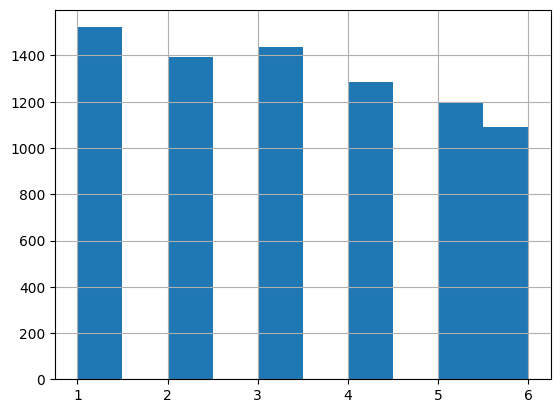

col:  IUFL


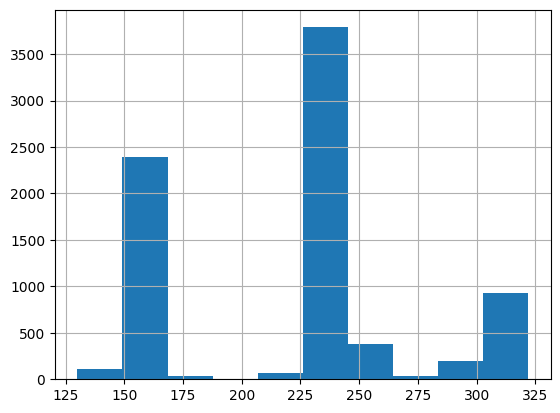

col:  EUFL


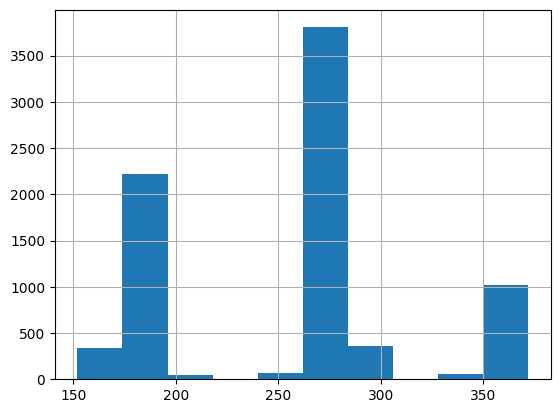

col:  IUFR


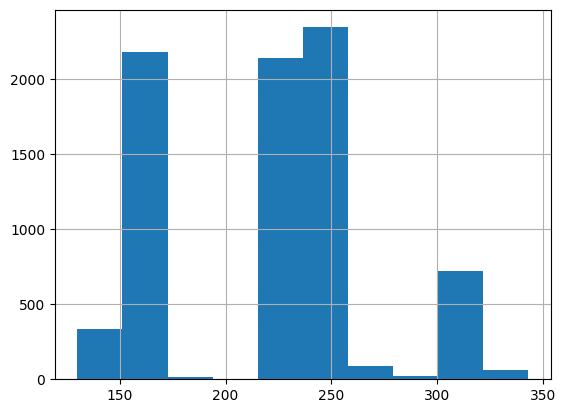

col:  EUFR


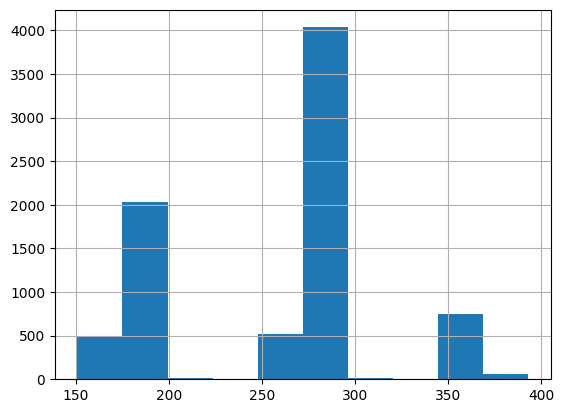

col:  IURL


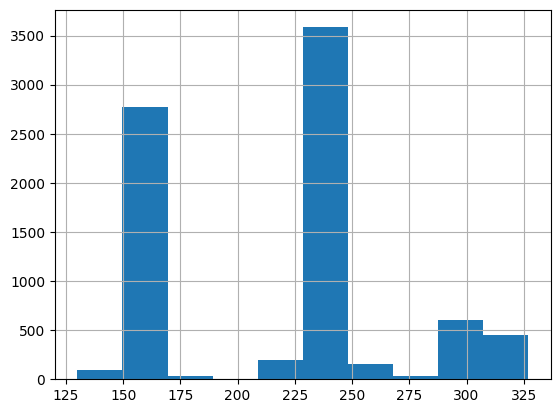

col:  EURL


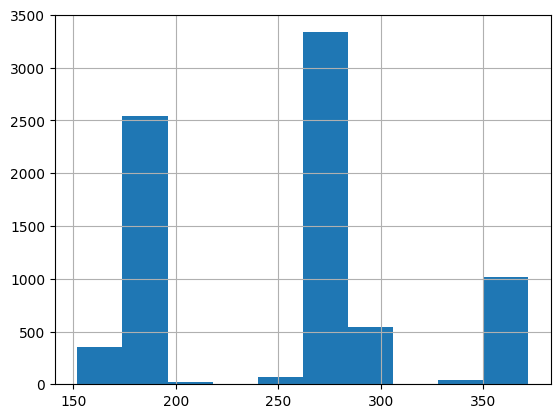

col:  IURR


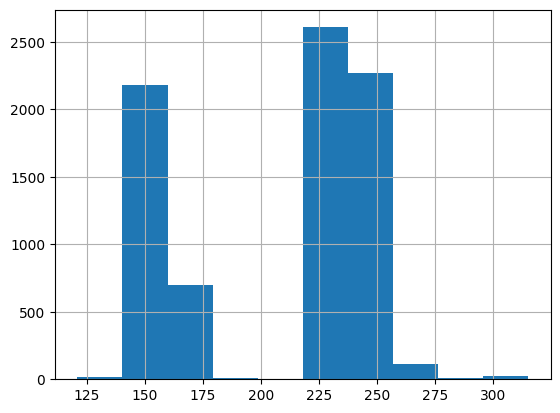

col:  EURR


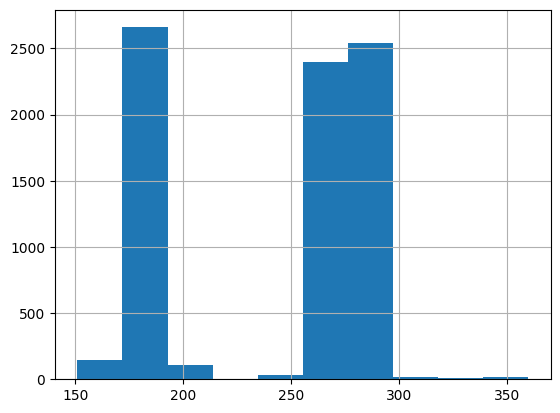

col:  Temperature


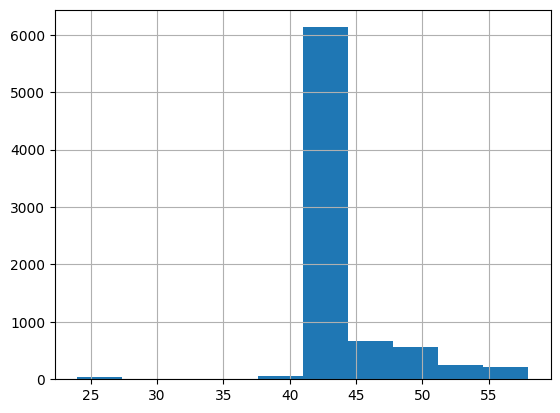

col:  Health_Mastitis


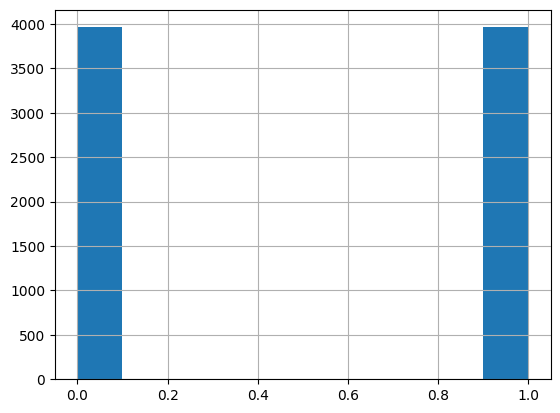

In [6]:
import matplotlib.pyplot as plt

columns = df.columns
for col in columns:
    print("col: ", col)
    df[col].hist()
    plt.show()

In [7]:
# Split data into training, test, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

print("Training set size:", X_train.shape[0], "or", round(X_train.shape[0]/x.shape[0]*100, 1), "%")
print("Test set size:", X_test.shape[0], "or", round(X_test.shape[0]/x.shape[0]*100, 1), "%")
print("Validation set size:", X_val.shape[0], "or", round(X_val.shape[0]/x.shape[0]*100, 1), "%")

Training set size: 5545 or 70.0 %
Test set size: 1592 or 20.1 %
Validation set size: 785 or 9.9 %


In [8]:
# Reshape the input data for LSTM (samples, time steps, features)
n_features = X_train.shape[1]
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, n_features))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, n_features))
X_val_reshaped = X_val.values.reshape((X_val.shape[0], 1, n_features))

X_val_reshaped

array([[[  6, 231, 275, ..., 232, 272,  43]],

       [[  4, 159, 191, ..., 154, 190,  43]],

       [[  3, 231, 267, ..., 231, 269,  43]],

       ...,

       [[  1, 270, 278, ..., 274, 296,  43]],

       [[  1, 272, 295, ..., 270, 288,  43]],

       [[  1, 304, 328, ..., 267, 296,  56]]])

# LSTM Model

In [9]:
# Define and compile the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(1, n_features)),
    LSTM(50),
    Dense(1, activation='sigmoid')
])


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=50, validation_data=(X_val_reshaped, y_val))

Epoch 1/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7513 - loss: 0.5969 - val_accuracy: 0.8675 - val_loss: 0.3514
Epoch 2/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8754 - loss: 0.3352 - val_accuracy: 0.8713 - val_loss: 0.3360
Epoch 3/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8704 - loss: 0.3391 - val_accuracy: 0.8803 - val_loss: 0.3290
Epoch 4/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8764 - loss: 0.3163 - val_accuracy: 0.8815 - val_loss: 0.3226
Epoch 5/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8775 - loss: 0.3164 - val_accuracy: 0.8815 - val_loss: 0.3164
Epoch 6/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8785 - loss: 0.3142 - val_accuracy: 0.8739 - val_loss: 0.3430
Epoch 7/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8838 - loss: 0.3179 - val_accuracy: 0.8739 - val_loss: 0.3270
Epoch 8/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8857 - loss: 0.3158 - val_accuracy: 0.

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 50)          │        12,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,355 (380.30 KB)

 Trainable params: 32,451 (126.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 64,904 (253.54 KB)

In [13]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test)
print("Test Accuracy:", test_acc)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8604 - loss: 0.3398
Test Accuracy: 0.8712311387062073


In [14]:
# Making predictions
predictions = model.predict(X_test_reshaped)
binary_predictions = (predictions > 0.5).astype(int)

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [15]:
import pandas as pd

# Assuming 'predictions' are in the format returned by model.predict() and are probabilities
# Flatten the predictions array and round them off for better readability
predicted_probs = predictions.flatten().round(2)

# Create a DataFrame from the test set features
test_features = pd.DataFrame(X_test_reshaped.reshape(X_test_reshaped.shape[0], n_features), columns=X_test.columns)

# Add the predictions and the actual labels to the DataFrame
test_features['Predicted Probability'] = predicted_probs
test_features['Actual Label'] = y_test  

# Sort the DataFrame by 'Predicted Probability' to get the top predictions
test_features_sorted = test_features.sort_values(by='Predicted Probability', ascending=False)

In [16]:
# Display the top 5 predictions
top_5_predictions = test_features_sorted.head(5)
print(top_5_predictions)

      Months_after_giving_birth  IUFL  EUFL  IUFR  EUFR  IURL  EURL  IURR  \
991                           1   307   364   161   180   153   178   163   
398                           5   239   277   311   363   231   273   237   
395                           3   241   278   239   282   314   367   240   
1337                          2   234   281   243   276   310   353   242   
1339                          1   242   284   309   360   240   284   245   

      EURR  Temperature  Predicted Probability  Actual Label  
991    182           47                    1.0             1  
398    275           50                    1.0             1  
395    285           43                    1.0             1  
1337   283           48                    1.0             1  
1339   280           43                    1.0             1  


In [17]:
 top_5_predictions.to_csv("top_5_predictions_v1.0.csv", index=False)
top_5_predictions.info

<bound method DataFrame.info of       Months_after_giving_birth  IUFL  EUFL  IUFR  EUFR  IURL  EURL  IURR  \
991                           1   307   364   161   180   153   178   163   
398                           5   239   277   311   363   231   273   237   
395                           3   241   278   239   282   314   367   240   
1337                          2   234   281   243   276   310   353   242   
1339                          1   242   284   309   360   240   284   245   

      EURR  Temperature  Predicted Probability  Actual Label  
991    182           47                    1.0             1  
398    275           50                    1.0             1  
395    285           43                    1.0             1  
1337   283           48                    1.0             1  
1339   280           43                    1.0             1  >

In [18]:
# Convert probabilities to binary predictions
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

In [19]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)

# Model Evaluation

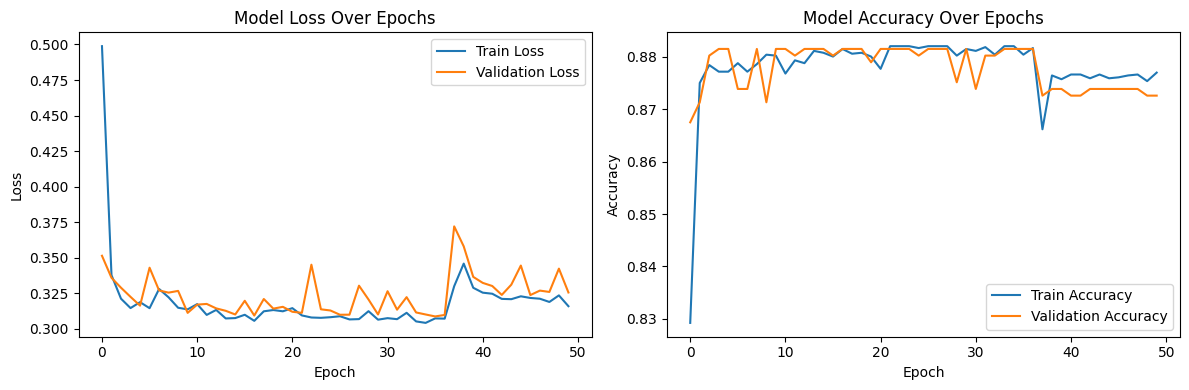

In [20]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

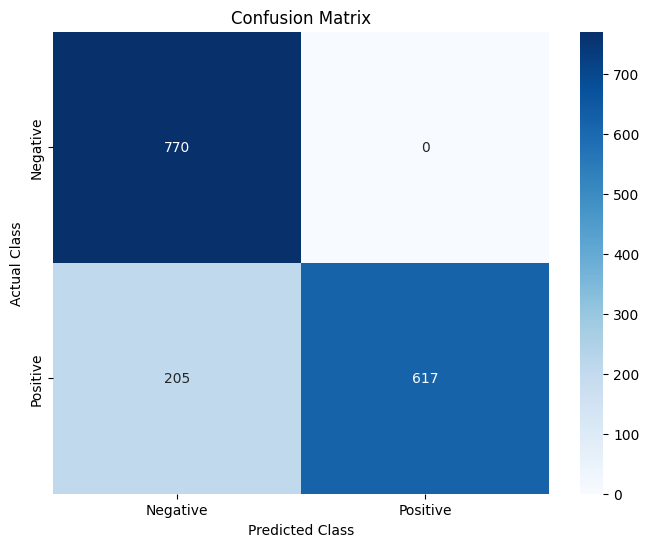

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the labels for the confusion matrix (adjust labels for your specific case)
labels = ['Negative', 'Positive']

# Create a heatmap from the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
accuracy = accuracy_score(y_test, binary_predictions)
precision = precision_score(y_test, binary_predictions)
recall = recall_score(y_test, binary_predictions)
f1 = f1_score(y_test, binary_predictions)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8712311557788944
Precision: 1.0
Recall: 0.7506082725060828
F1 Score: 0.857539958304378


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


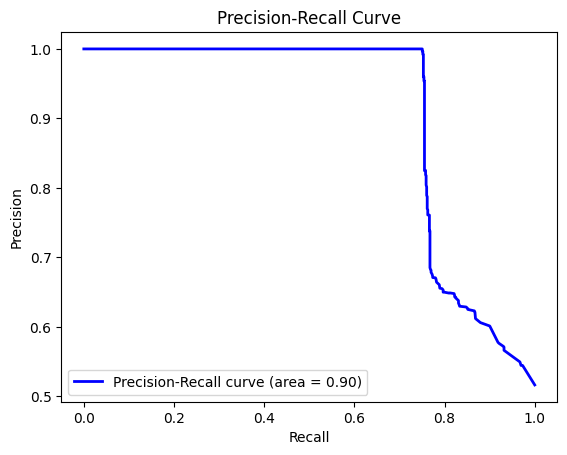

In [23]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Predict probabilities
y_pred_prob = model.predict(X_test_reshaped).ravel()
# Compute precision-recall pairs for different probability thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Compute average precision score
average_precision = average_precision_score(y_test, y_pred_prob)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='b', lw=2, label=f'Precision-Recall curve (area = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

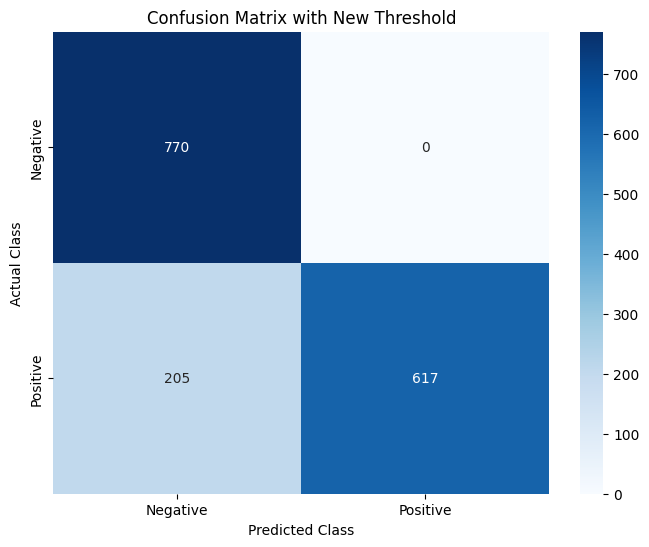

In [24]:
# Adjusting threshold to prioritize recall
new_threshold = 0.4
new_binary_predictions = (predictions > new_threshold).astype(int)
new_conf_matrix = confusion_matrix(y_test, new_binary_predictions)

# Redisplay new confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(new_conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix with New Threshold')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

True Negatives (TN): 770
False Positives (FP): 0
False Negatives (FN): 205
True Positives (TP): 617


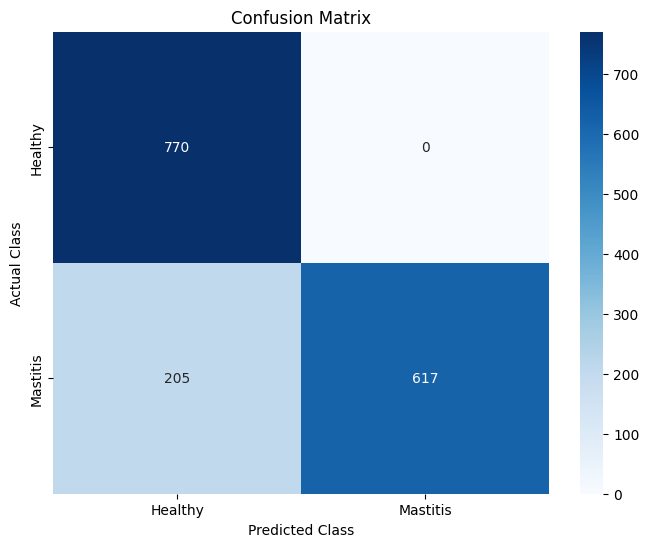

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming binary_predictions and y_test are already defined

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)

# Extract TN, FP, FN, TP
TN, FP, FN, TP = conf_matrix.ravel()

# Print TN, FP, FN, TP
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Positives (TP): {TP}")

# Optional: Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=['Healthy', 'Mastitis'], yticklabels=['Healthy', 'Mastitis'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


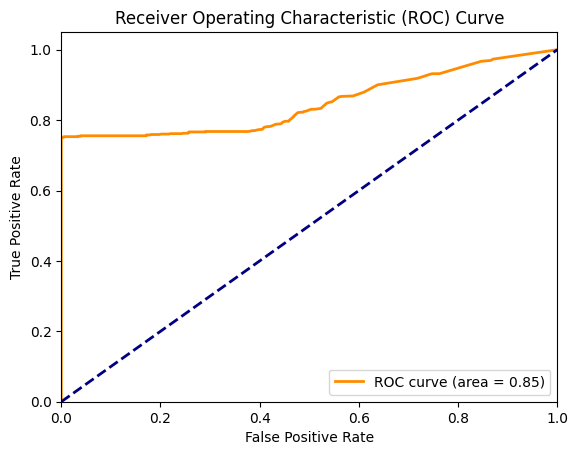

In [26]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities
y_pred_prob = model.predict(X_test_reshaped).ravel()

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [27]:
print(model.output_shape)

(None, 1)


In [28]:
# Making predictions
predictions = model.predict(X_test_reshaped)
binary_predictions = (predictions > 0.5).astype(int)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


# SHAP Value Calculation and Visualization

In [29]:
X_train_flat = X_train.values
X_test_flat = X_test.values

In [30]:
def model_predict(data):
    reshaped_data = data.reshape(data.shape[0], 1, data.shape[1])
    return model.predict(reshaped_data)

In [31]:
# Initialize KernelExplainer with a sample of the training data
explainer = shap.KernelExplainer(model_predict, shap.sample(X_train_flat, 100))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [32]:
shap_values = explainer.shap_values(X_test_flat[:50], nsamples=100)

  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━

In [33]:
# Ensure that single_record_features is correctly shaped
single_record_features = X_test_flat[0]  # This assumes X_test_flat is (samples, features) and already 2D

# Check the shape or length
print("Features length:", len(single_record_features))

# Select SHAP values for a single record, assuming shap_values is a 2D array
single_record_shap_values = shap_values[0]
print("Correctly selected SHAP values length:", len(single_record_shap_values))

Features length: 10
Correctly selected SHAP values length: 50


In [34]:
explainer.expected_value

array([0.55205204])

In [35]:
single_record_features = X_test_flat[0] 
print("Features shape:", single_record_features.shape)

print("SHAP values:", single_record_shap_values)
print("Feature values:", single_record_features)


Features shape: (10,)
SHAP values: [[ 0.01783449 -0.02112582 -0.06068655 -0.05268639 -0.06625411 -0.01650921
  -0.1168991   0.01490462 -0.05778019 -0.01670075]
 [ 0.         -0.13610548  0.         -0.08805519  0.         -0.05726208
  -0.09447764  0.          0.          0.        ]
 [ 0.         -0.23828506 -0.0358196  -0.12153565 -0.02430315 -0.05229521
  -0.07634836 -0.00219362  0.17487867  0.        ]
 [ 0.         -0.13160468 -0.02920897 -0.09043229 -0.03109852  0.
  -0.05706304  0.          0.         -0.03649117]
 [ 0.         -0.02942508 -0.0898758  -0.02053819 -0.04811631 -0.00877113
  -0.11356634  0.         -0.06560929  0.        ]
 [ 0.          0.         -0.01160805 -0.03824707 -0.02505941  0.2615458
   0.42137065 -0.02318008 -0.08375591 -0.05474298]
 [-0.02488889 -0.17275581  0.         -0.16752143 -0.05268812  0.
  -0.12142364  0.          0.08434247  0.07903464]
 [ 0.         -0.03301234 -0.06961004  0.         -0.08768827 -0.01011053
  -0.14018959 -0.00781183 -0.0170

In [36]:
shap.initjs()

# Generate the force plot for the first record correctly
shap.force_plot(
    explainer.expected_value[0], shap_values[0][1],        # Use the flattened SHAP values
    X_test_flat[0],       # Feature values for the single record
    feature_names=X_test.columns.tolist()  # Names of the features
)

In [37]:
shap_html = shap.force_plot(
    explainer.expected_value[0], shap_values[0][1],        # Use the flattened SHAP values
    X_test_flat[0],       # Feature values for the single record
    feature_names=X_test.columns.tolist()  # Names of the features
)

shap.save_html('/kaggle/working/force_plot_1.html', shap_html)

In [38]:
shap.initjs()

# Generate the force plot for the first record correctly
shap.force_plot(
    explainer.expected_value[0], shap_values[0][1],        # Use the flattened SHAP values
    X_test_flat[1],       # Feature values for the single record
    feature_names=X_test.columns.tolist()  # Names of the features
)

In [39]:
shap_html = shap.force_plot(
    explainer.expected_value[0], shap_values[0][1],        # Use the flattened SHAP values
    X_test_flat[1],       # Feature values for the single record
    feature_names=X_test.columns.tolist()  # Names of the features
)

shap.save_html('/kaggle/working/force_plot_2.html', shap_html)

In [40]:
shap_values

[array([[ 0.01783449, -0.02112582, -0.06068655, -0.05268639, -0.06625411,
         -0.01650921, -0.1168991 ,  0.01490462, -0.05778019, -0.01670075],
        [ 0.        , -0.13610548,  0.        , -0.08805519,  0.        ,
         -0.05726208, -0.09447764,  0.        ,  0.        ,  0.        ],
        [ 0.        , -0.23828506, -0.0358196 , -0.12153565, -0.02430315,
         -0.05229521, -0.07634836, -0.00219362,  0.17487867,  0.        ],
        [ 0.        , -0.13160468, -0.02920897, -0.09043229, -0.03109852,
          0.        , -0.05706304,  0.        ,  0.        , -0.03649117],
        [ 0.        , -0.02942508, -0.0898758 , -0.02053819, -0.04811631,
         -0.00877113, -0.11356634,  0.        , -0.06560929,  0.        ],
        [ 0.        ,  0.        , -0.01160805, -0.03824707, -0.02505941,
          0.2615458 ,  0.42137065, -0.02318008, -0.08375591, -0.05474298],
        [-0.02488889, -0.17275581,  0.        , -0.16752143, -0.05268812,
          0.        , -0.1214236

In [41]:
shap_values_class1 = shap_values[0]
shap_values_class1

array([[ 0.01783449, -0.02112582, -0.06068655, -0.05268639, -0.06625411,
        -0.01650921, -0.1168991 ,  0.01490462, -0.05778019, -0.01670075],
       [ 0.        , -0.13610548,  0.        , -0.08805519,  0.        ,
        -0.05726208, -0.09447764,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.23828506, -0.0358196 , -0.12153565, -0.02430315,
        -0.05229521, -0.07634836, -0.00219362,  0.17487867,  0.        ],
       [ 0.        , -0.13160468, -0.02920897, -0.09043229, -0.03109852,
         0.        , -0.05706304,  0.        ,  0.        , -0.03649117],
       [ 0.        , -0.02942508, -0.0898758 , -0.02053819, -0.04811631,
        -0.00877113, -0.11356634,  0.        , -0.06560929,  0.        ],
       [ 0.        ,  0.        , -0.01160805, -0.03824707, -0.02505941,
         0.2615458 ,  0.42137065, -0.02318008, -0.08375591, -0.05474298],
       [-0.02488889, -0.17275581,  0.        , -0.16752143, -0.05268812,
         0.        , -0.12142364,  0.        

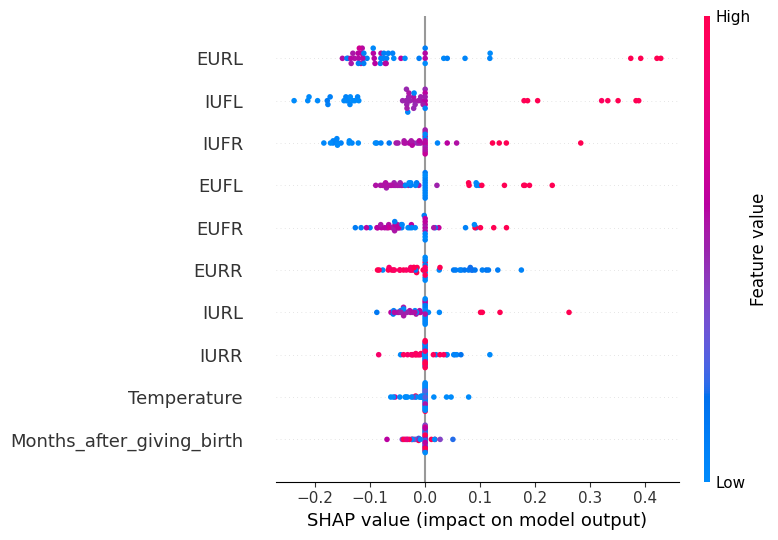

<Figure size 1800x1800 with 0 Axes>

In [42]:
shap.summary_plot(
    shap_values_class1,
    X_test_flat[:50],  # Use the features corresponding to the SHAP values
    feature_names=X_test.columns.tolist()[:15]  # Ensure the feature names list is correctly aligned
)
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 18))
plt.savefig('shap_summary_plot.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

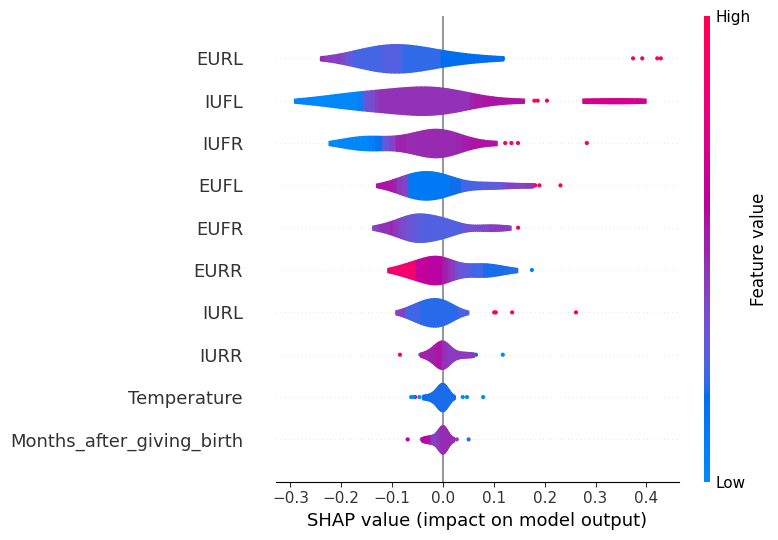

<Figure size 1800x1800 with 0 Axes>

In [43]:
shap.summary_plot(
    shap_values_class1,
    X_test_flat[:50],  # Use the features corresponding to the SHAP values
    feature_names=X_test.columns.tolist()[:15],  # Ensure the feature names list is correctly aligned
    plot_type="violin"
)
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 18))
plt.savefig('shap_summary_plot1.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

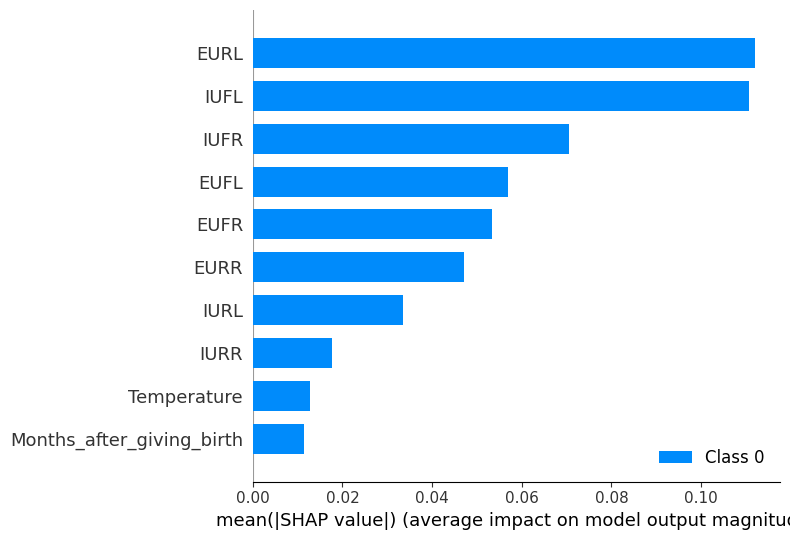

<Figure size 1800x1800 with 0 Axes>

In [44]:
shap.summary_plot(
    shap_values,
    X_test_flat[:50],  # Use the features corresponding to the SHAP values
    feature_names=X_test.columns.tolist()[:15],  # Ensure the feature names list is correctly aligned
    plot_type="bar"
)
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 18))
plt.savefig('shap_summary_plot1.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [45]:
shap.plots.force(explainer.expected_value,shap_values[0],feature_names=X_test.columns.tolist())

In [46]:
shap_html = shap.plots.force(explainer.expected_value,shap_values[0],feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/General_force_plot.html', shap_html)

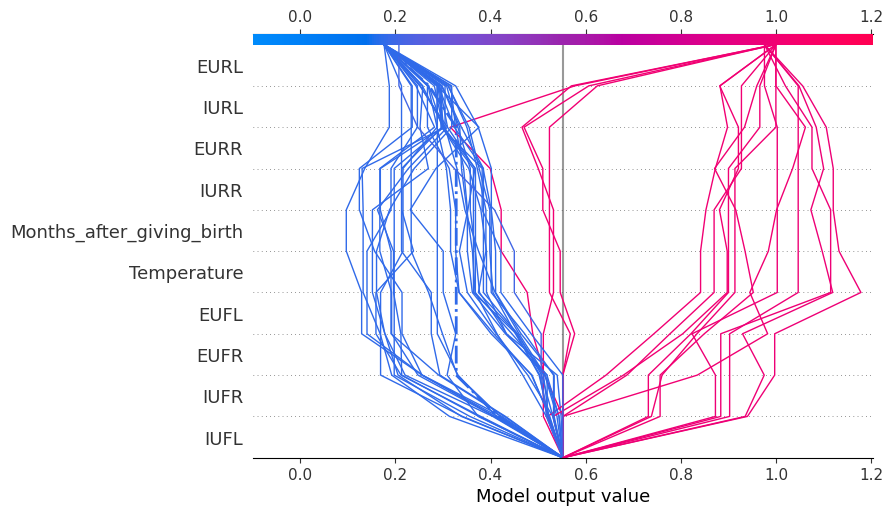

In [47]:
shap.decision_plot(explainer.expected_value, shap_values[0], feature_names=X_test.columns.tolist(),link="identity", highlight=1,legend_location="best",
                  feature_order="hclust")

In [48]:
# Flatten the SHAP values to match the expected shape (samples, features)
shap_values_flat_1 = np.array(shap_values).reshape((50, 10))
shap_values_flat_1
shap_values_expl_1 = shap.Explanation(values=shap_values_flat_1, base_values=explainer.expected_value, data=X_test_flat[:50], feature_names=X_test.columns.tolist())

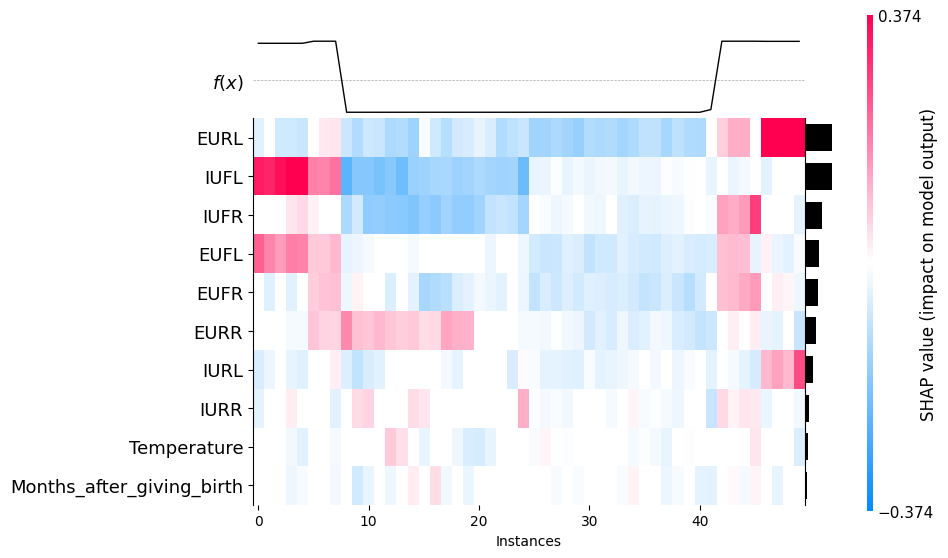

In [49]:
shap.plots.heatmap(shap_values_expl_1, max_display=15)

In [50]:
top_5_predictions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 991 to 1339
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Months_after_giving_birth  5 non-null      int64  
 1   IUFL                       5 non-null      int64  
 2   EUFL                       5 non-null      int64  
 3   IUFR                       5 non-null      int64  
 4   EUFR                       5 non-null      int64  
 5   IURL                       5 non-null      int64  
 6   EURL                       5 non-null      int64  
 7   IURR                       5 non-null      int64  
 8   EURR                       5 non-null      int64  
 9   Temperature                5 non-null      int64  
 10  Predicted Probability      5 non-null      float32
 11  Actual Label               5 non-null      int64  
dtypes: float32(1), int64(11)
memory usage: 500.0 bytes


In [51]:
X_sample_test = top_5_predictions.drop(columns=[ 'Predicted Probability','Actual Label'])
X_sample_test

Months_after_giving_birth  IUFL  EUFL  IUFR  EUFR  IURL  EURL  IURR  \
991                           1   307   364   161   180   153   178   163   
398                           5   239   277   311   363   231   273   237   
395                           3   241   278   239   282   314   367   240   
1337                          2   234   281   243   276   310   353   242   
1339                          1   242   284   309   360   240   284   245   

      EURR  Temperature  
991    182           47  
398    275           50  
395    285           43  
1337   283           48  
1339   280           43

In [52]:
Y_sample_test = top_5_predictions['Actual Label'].values
Y_sample_test

array([1, 1, 1, 1, 1])

In [53]:
X_test_flat[:20]
shap_values

[array([[ 0.01783449, -0.02112582, -0.06068655, -0.05268639, -0.06625411,
         -0.01650921, -0.1168991 ,  0.01490462, -0.05778019, -0.01670075],
        [ 0.        , -0.13610548,  0.        , -0.08805519,  0.        ,
         -0.05726208, -0.09447764,  0.        ,  0.        ,  0.        ],
        [ 0.        , -0.23828506, -0.0358196 , -0.12153565, -0.02430315,
         -0.05229521, -0.07634836, -0.00219362,  0.17487867,  0.        ],
        [ 0.        , -0.13160468, -0.02920897, -0.09043229, -0.03109852,
          0.        , -0.05706304,  0.        ,  0.        , -0.03649117],
        [ 0.        , -0.02942508, -0.0898758 , -0.02053819, -0.04811631,
         -0.00877113, -0.11356634,  0.        , -0.06560929,  0.        ],
        [ 0.        ,  0.        , -0.01160805, -0.03824707, -0.02505941,
          0.2615458 ,  0.42137065, -0.02318008, -0.08375591, -0.05474298],
        [-0.02488889, -0.17275581,  0.        , -0.16752143, -0.05268812,
          0.        , -0.1214236

In [54]:
X_sample_test_flat = X_sample_test.values
len(X_sample_test_flat)

5

In [55]:
# Initialize KernelExplainer with a sample of the training data
explainer = shap.KernelExplainer(model_predict, shap.sample(X_sample_test_flat))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [56]:
shap_values_v1 = explainer.shap_values(X_sample_test_flat, nsamples=100)

  0%|          | 0/5 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [57]:
shap_values_v1

[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.01713217,  0.05180794,  0.        ,
         -0.11858821, -0.01196161,  0.04128873,  0.063716  , -0.04274937],
        [ 0.        ,  0.        ,  0.        , -0.09233932,  0.        ,
          0.        ,  0.05519804,  0.06343402, -0.0272588 ,  0.        ],
        [ 0.        ,  0.        ,  0.        , -0.11785862,  0.        ,
          0.05436954,  0.06251622,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.01062016,  0.02863134,  0.11697947, -0.09929134,
          0.03941919, -0.13242721,  0.01405193,  0.02266151,  0.        ]])]

In [58]:
shap.initjs()
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values_v1[0][0],X_sample_test_flat[0],       # Feature values for the single record
    feature_names=X_test.columns.tolist())

In [59]:
shap_html = shap.force_plot(explainer.expected_value,shap_values_v1[0][0],X_sample_test_flat[0],       # Feature values for the single record
    feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/prediction_force_plot_0.html', shap_html)

In [60]:
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values_v1[0][1],X_sample_test_flat[1],       # Feature values for the single record
    feature_names=X_test.columns.tolist())

In [61]:
shap_html = shap.force_plot(explainer.expected_value,shap_values_v1[0][1],X_sample_test_flat[1],       # Feature values for the single record
    feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/prediction_force_plot_1.html', shap_html)

In [62]:
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values_v1[0][2],X_sample_test_flat[2],       # Feature values for the single record
    feature_names=X_test.columns.tolist())

In [63]:
shap_html = shap.force_plot(explainer.expected_value,shap_values_v1[0][2],X_sample_test_flat[2],       # Feature values for the single record
    feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/prediction_force_plot_2.html', shap_html)

In [64]:
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values_v1[0][3],X_sample_test_flat[3],       # Feature values for the single record
    feature_names=X_test.columns.tolist())

In [65]:
shap_html = shap.force_plot(explainer.expected_value,shap_values_v1[0][3],X_sample_test_flat[3],       # Feature values for the single record
    feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/prediction_force_plot_3.html', shap_html)

In [66]:
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values_v1[0][4],X_sample_test_flat[4],       # Feature values for the single record
    feature_names=X_test.columns.tolist())

In [67]:
shap_html = shap.force_plot(explainer.expected_value,shap_values_v1[0][4],X_sample_test_flat[4],       # Feature values for the single record
    feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/prediction_force_plot_4.html', shap_html)

In [68]:
shap_test = shap_values_v1[0]

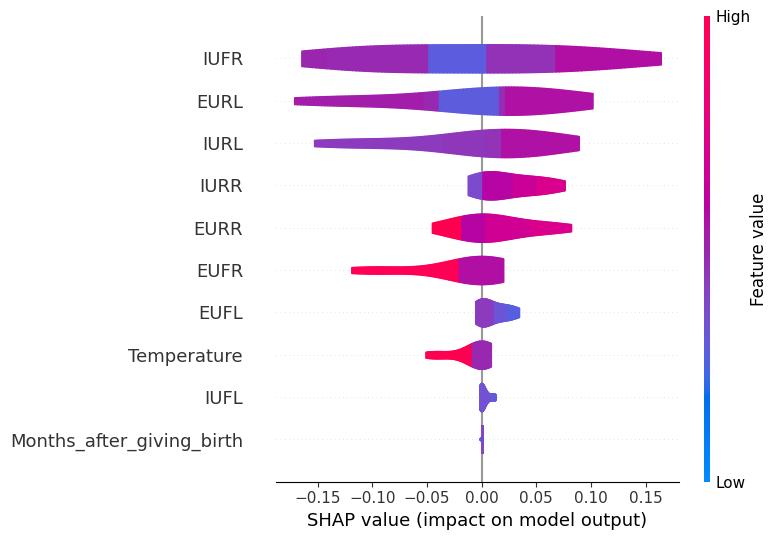

In [69]:
shap.summary_plot(
    shap_test,
    X_sample_test_flat,
    feature_names=X_test.columns.tolist()[:15], 
    plot_type="violin"
    
)

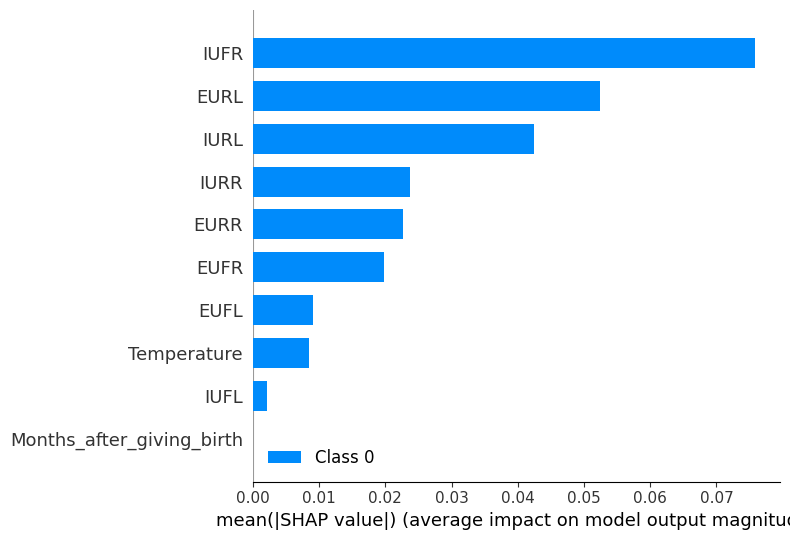

In [70]:
shap.summary_plot(
    shap_values_v1,
    X_sample_test_flat,
    feature_names=X_test.columns.tolist()[:15], 
    plot_type="bar"
)

In [71]:
shap.plots.force(explainer.expected_value,shap_values_v1[0],feature_names=X_test.columns.tolist())

In [72]:
  shap_html = shap.force_plot(
    explainer.expected_value,shap_values_v1[0],feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/top_5_predictions_force_plot_1.html', shap_html)

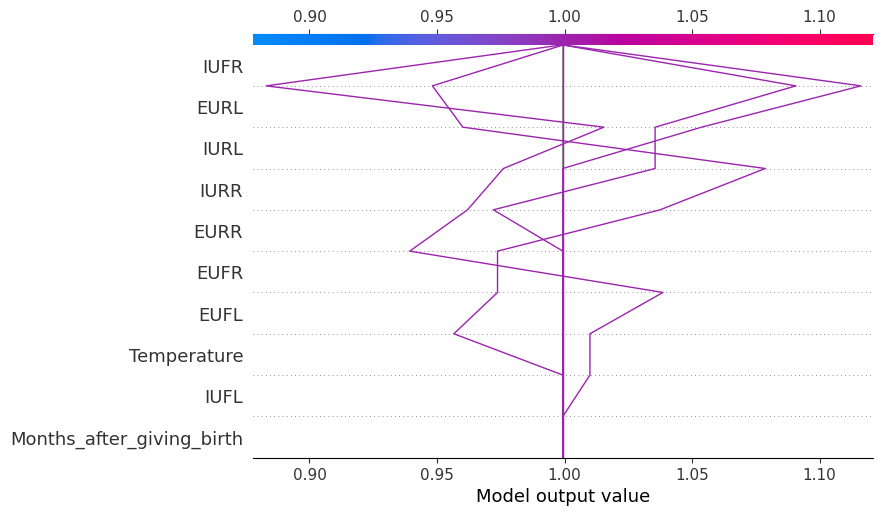

In [73]:
shap.decision_plot(explainer.expected_value, shap_values_v1[0], feature_names=X_test.columns.tolist(),)

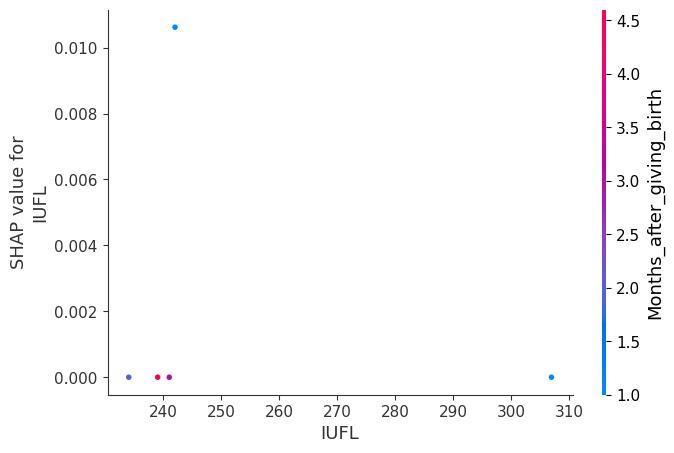

In [74]:
shap.dependence_plot(1, shap_values_v1[0], X_sample_test_flat,feature_names=X_test.columns.tolist())

In [75]:
# Flatten the SHAP values to match the expected shape (samples, features)
shap_values_flat = np.array(shap_values_v1).reshape((5, 10))
shap_values_flat


array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.01713217,  0.05180794,  0.        ,
        -0.11858821, -0.01196161,  0.04128873,  0.063716  , -0.04274937],
       [ 0.        ,  0.        ,  0.        , -0.09233932,  0.        ,
         0.        ,  0.05519804,  0.06343402, -0.0272588 ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.11785862,  0.        ,
         0.05436954,  0.06251622,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.01062016,  0.02863134,  0.11697947, -0.09929134,
         0.03941919, -0.13242721,  0.01405193,  0.02266151,  0.        ]])

In [76]:
import shap
shap_values_expl = shap.Explanation(values=shap_values_flat, base_values=explainer.expected_value, data=X_test_flat, feature_names=X_test.columns.tolist())
shap_values_expl

.values =
array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.01713217,  0.05180794,  0.        ,
        -0.11858821, -0.01196161,  0.04128873,  0.063716  , -0.04274937],
       [ 0.        ,  0.        ,  0.        , -0.09233932,  0.        ,
         0.        ,  0.05519804,  0.06343402, -0.0272588 ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.11785862,  0.        ,
         0.05436954,  0.06251622,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.01062016,  0.02863134,  0.11697947, -0.09929134,
         0.03941919, -0.13242721,  0.01405193,  0.02266151,  0.        ]])

.base_values =
array([0.99935155])

.data =
array([[  5, 242, 281, ..., 238, 282,  43],
       [  1, 153, 183, ..., 161, 176,  43],
       [  2, 151, 181, ..., 151, 181,  43],
       ...,
       [  5, 308, 363, ..., 161, 181,  47],
       [  3, 300, 359

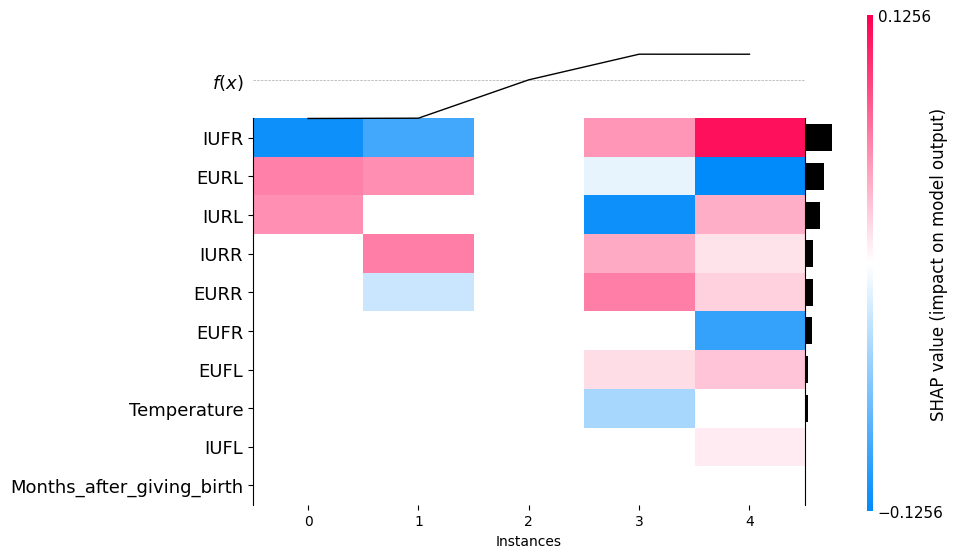

In [77]:
# Visualize SHAP values using heatmap
shap.plots.heatmap(shap_values_expl, max_display=15)

In [78]:
base_value = 0.19902058
float(base_value)

0.19902058

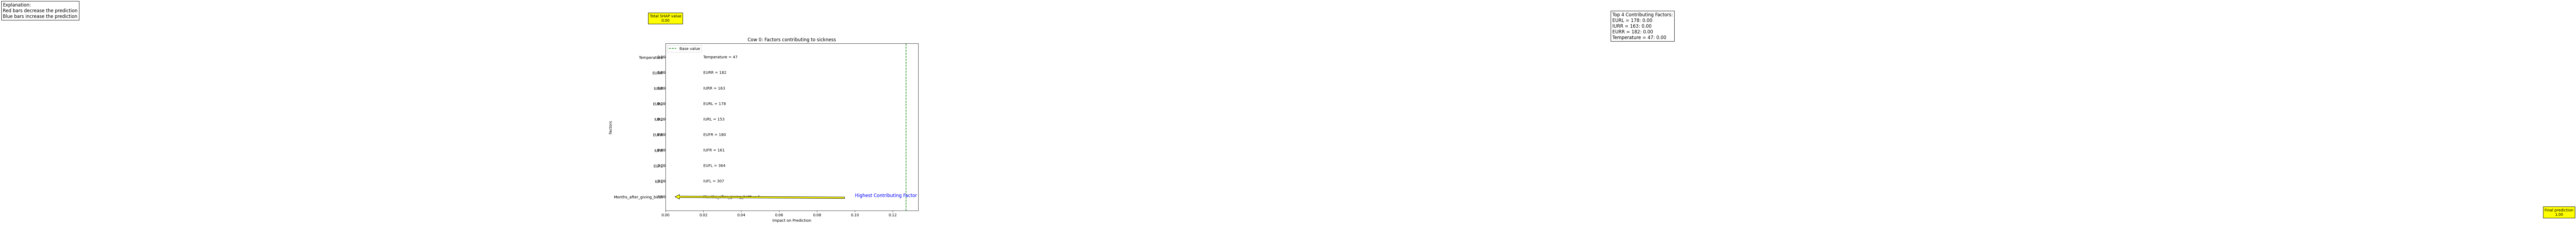

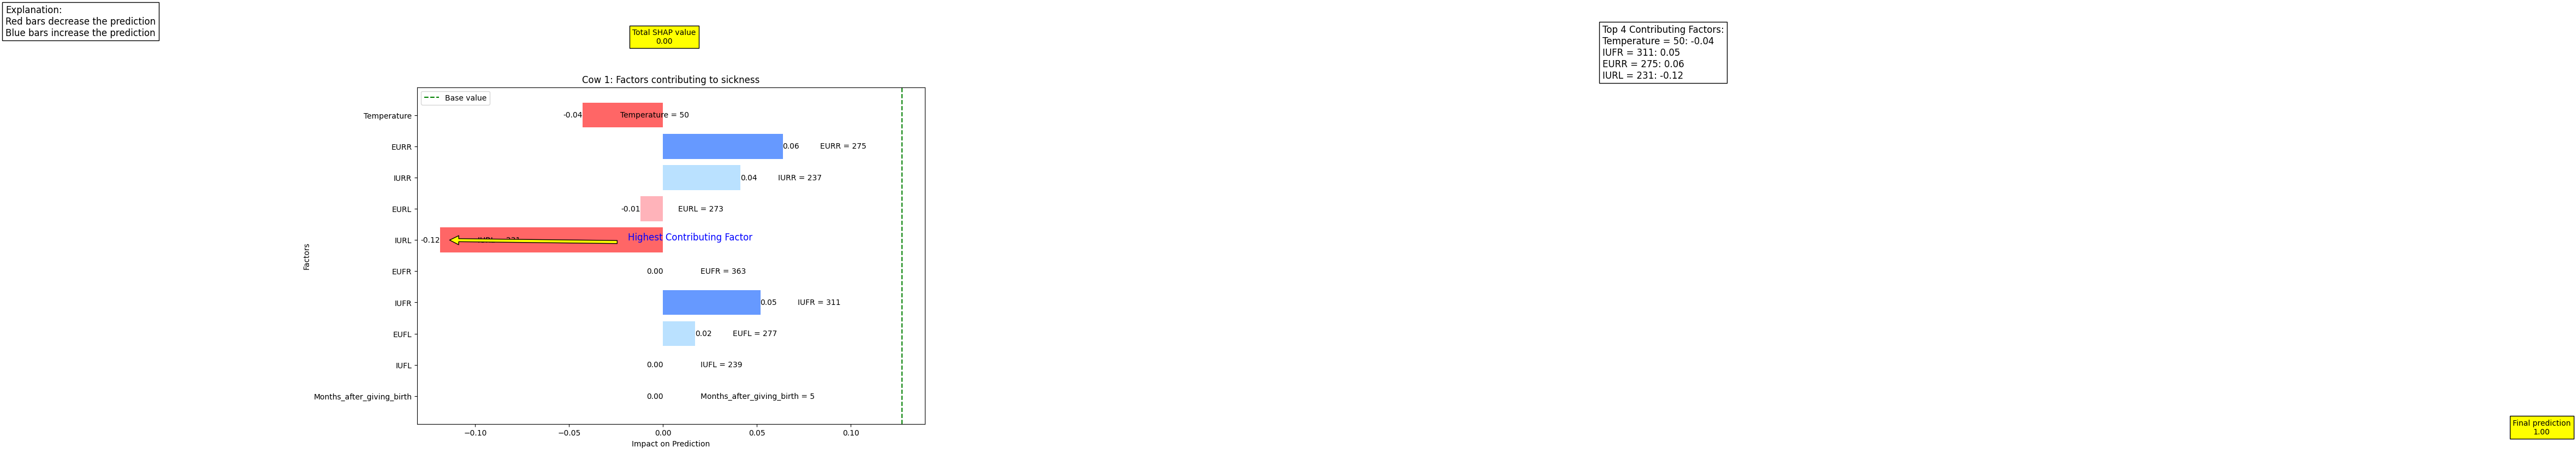

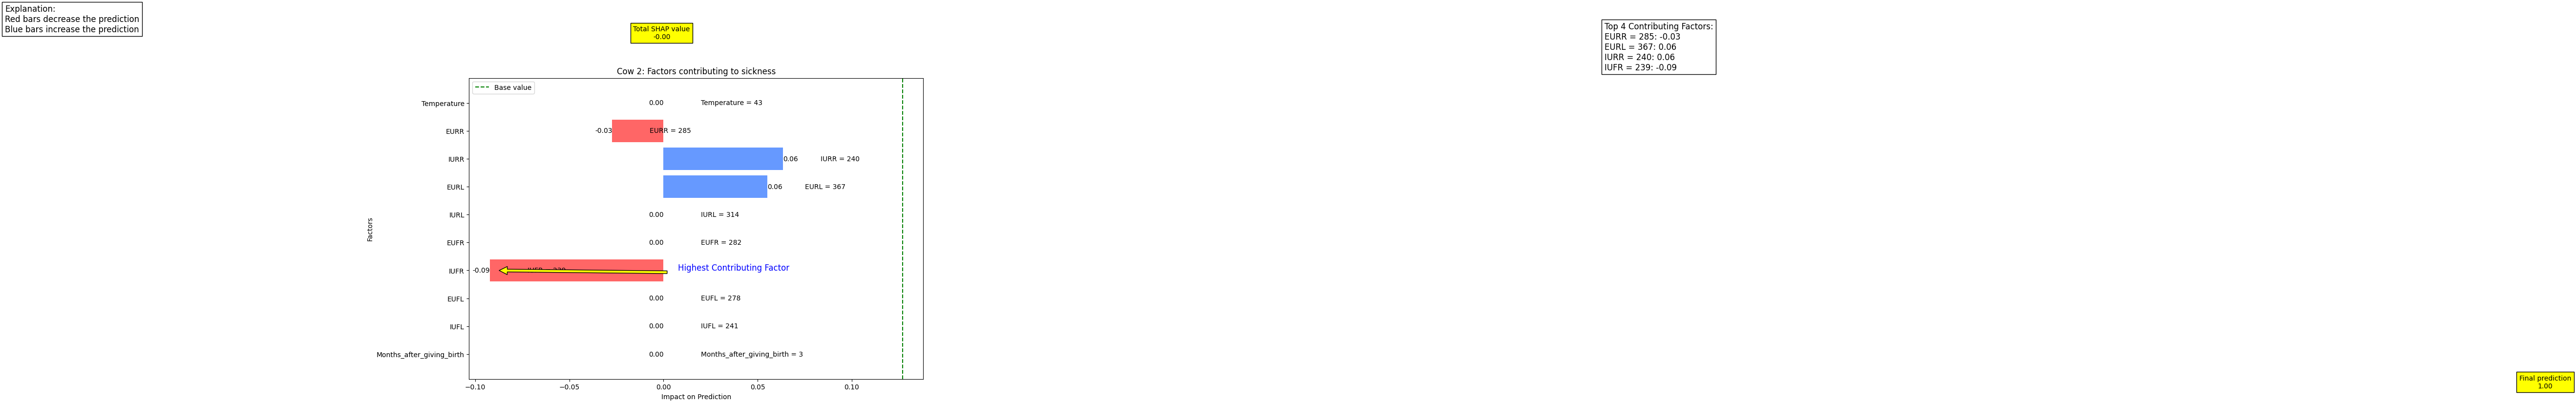

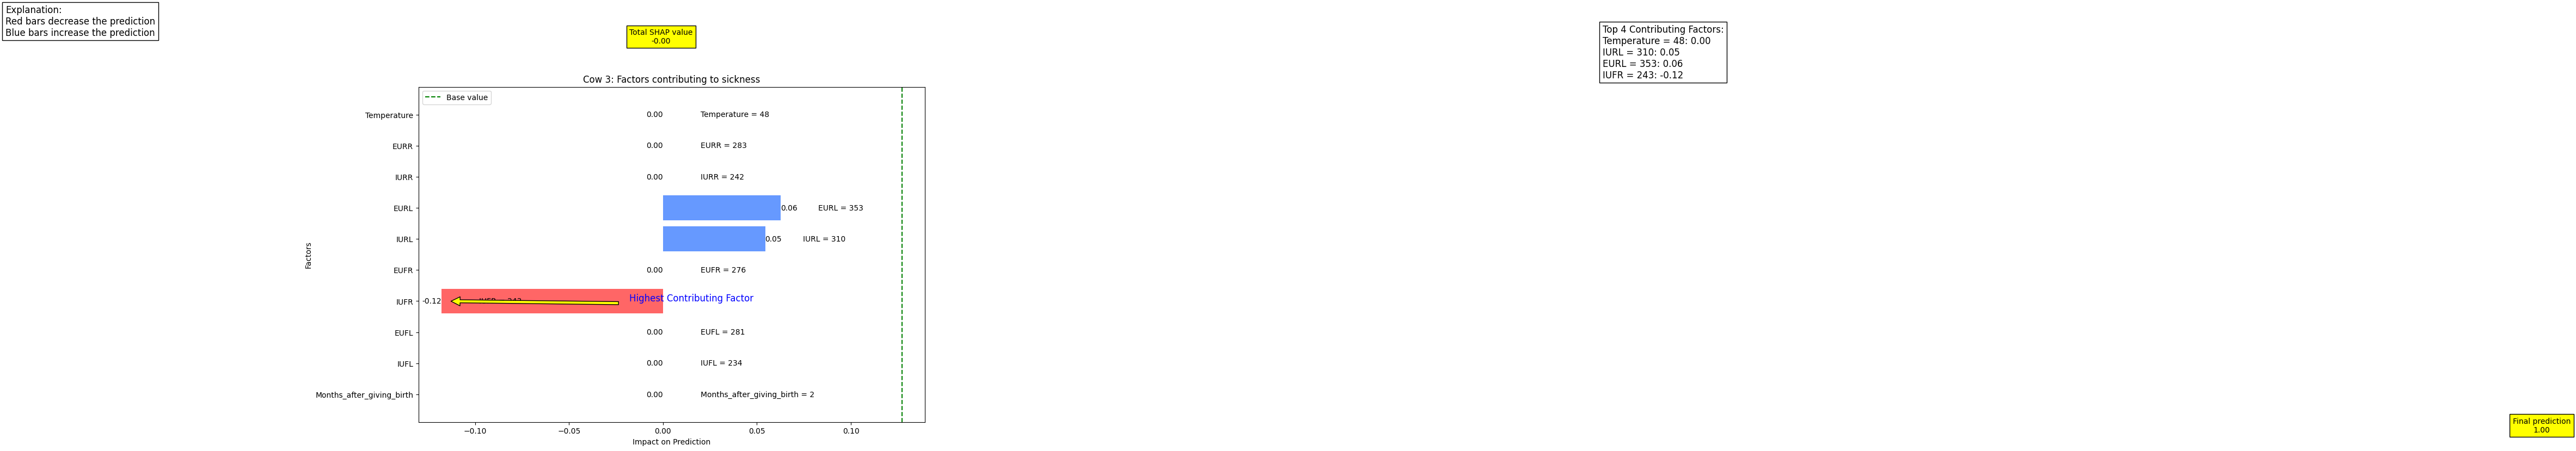

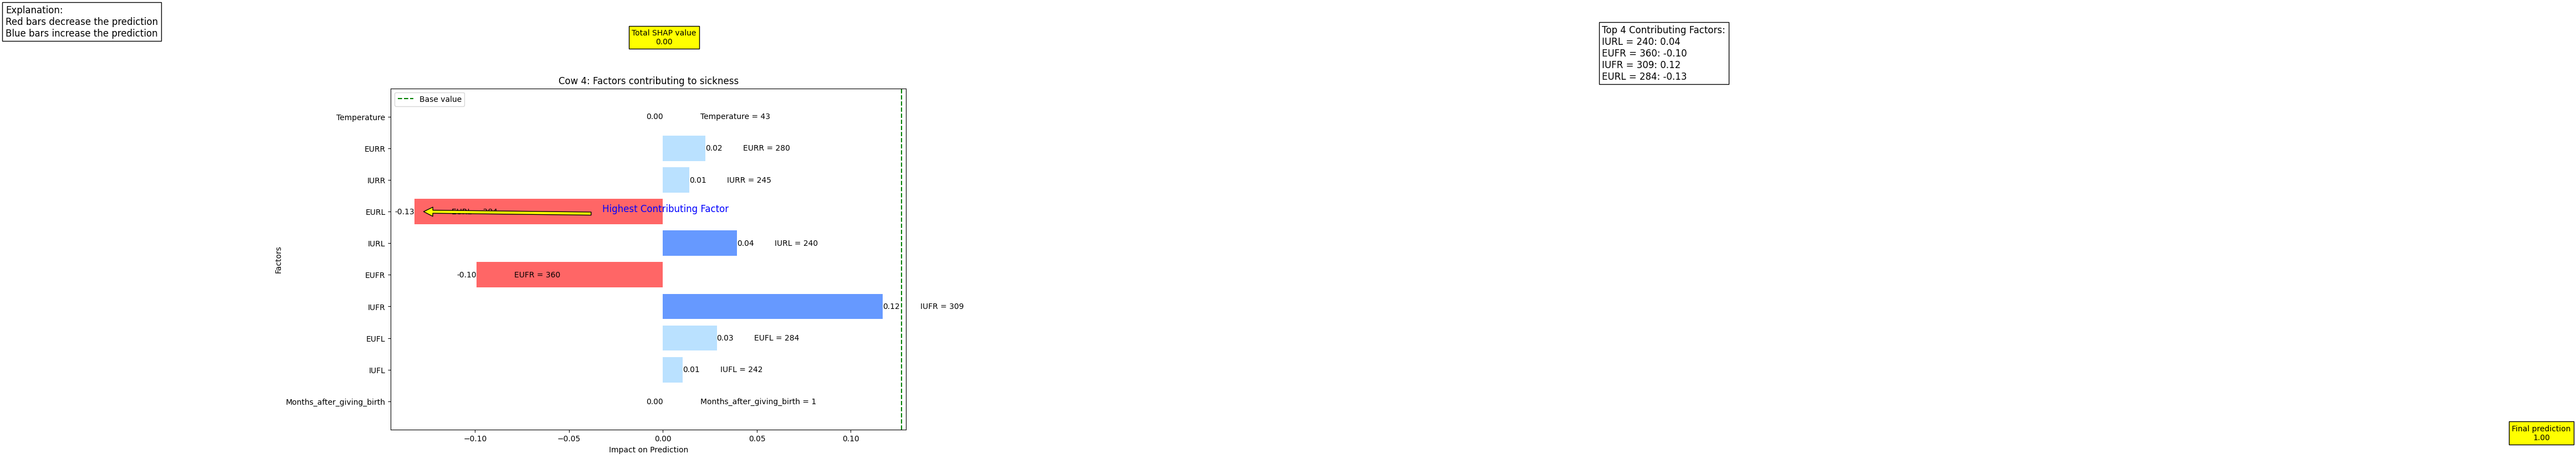

Custom waterfall plots generated for each cow.


In [79]:
# Extract feature names
feature_names = X_sample_test.columns.tolist() 

# Function to create and save custom waterfall plots
def create_custom_waterfall_plot(shap_values, feature_values, base_value, cow_id, is_sick, filename):
    # Calculate the final prediction
    final_prediction = 1    #base_value + sum(shap_values)

    # Pastel colors for the bars
    colors = ['#FFB3BA' if val < 0 else '#BAE1FF' for val in shap_values]

    # Identify the top 4 contributing factors by absolute SHAP value
    top_4_indices = np.argsort(np.abs(shap_values))[-4:]

    # Highlight top 4 contributing factors
    highlight_colors = ['#FF6666' if val < 0 else '#6699FF' for val in shap_values]
    for i in top_4_indices:
        colors[i] = highlight_colors[i]

    # Positions for the bars
    positions = np.arange(len(feature_names))

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    bars = ax.barh(positions, shap_values, color=colors)

    # Add the base value as a vertical line
    ax.axvline(base_value, color='green', linestyle='--', label='Base value')

    # Add annotations for the SHAP values and feature names
    for bar, feature, val in zip(bars, feature_values, shap_values):
        ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{val:.2f}', va='center', ha='left' if val > 0 else 'right', color='black')
        ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height() / 2, feature, va='center', ha='left', color='black')

    # Add explanations for the top 4 contributing factors
    explanation_text = 'Top 4 Contributing Factors:\n'
    for i in top_4_indices:
        explanation_text += f"{feature_values[i]}: {shap_values[i]:.2f}\n"
    plt.text(0.5, len(feature_names) + 1, explanation_text.strip(), va='center', ha='left', color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))

    # Highlight the highest contributing factor
    max_shap_value = max(shap_values, key=abs)
    max_feature_index = shap_values.tolist().index(max_shap_value)
    ax.annotate('Highest Contributing Factor',
                 xy=(shap_values[max_feature_index], max_feature_index),
                 xytext=(shap_values[max_feature_index] + 0.1, max_feature_index),
                 arrowprops=dict(facecolor='yellow', shrink=0.05),
                 fontsize=12, color='blue', ha='left')

    # Add the final prediction as an annotation
    ax.text(final_prediction, -1, f'Final prediction\n{final_prediction:.2f}', va='center', ha='center', color='black', bbox=dict(facecolor='yellow', edgecolor='black'))

    # Add the total SHAP value as an annotation
    total_shap_value = sum(shap_values)
    ax.text(total_shap_value, len(feature_names) + 1.5, f'Total SHAP value\n{total_shap_value:.2f}', va='center', ha='center', color='black', bbox=dict(facecolor='yellow', edgecolor='black'))

    # Set labels and title
    ax.set_xlabel('Impact on Prediction')
    ax.set_ylabel('Factors')
    ax.set_title(f'Cow {cow_id}: Factors contributing to {"sickness" if is_sick else "health"}')
    ax.set_yticks(positions, feature_names)
    ax.set_yticklabels(feature_names)
    

    # Add explanation for colors
    ax.text(-0.35, len(feature_names) + 2, 'Explanation:\nRed bars decrease the prediction\nBlue bars increase the prediction',
             va='center', ha='left', color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))

    ax.legend()
    plt.show()
    # Save the plot
    plt.savefig(f'{filename}.png')
    plt.close()

# Loop through each cow and create a plot
for i in range(len(shap_values_flat)):
    cow_id = i  # Adjust according to your CSV structure
    is_sick = Y_sample_test[i]
    shap_values = shap_values_flat[i]
    feature_values = X_sample_test_flat[i].tolist()  # Exclude 'Predicted Probability' and 'Actual Label'
    feature_values = [f"{name} = {value}" for name, value in zip(feature_names, feature_values)]
    create_custom_waterfall_plot(shap_values, feature_values, 0.12711417, cow_id, is_sick, f'prediction_force_plot_{i}')

print("Custom waterfall plots generated for each cow.")

# Smooth Curve Model

Epoch 1/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8769 - loss: 0.3133 - val_accuracy: 0.8792 - val_loss: 0.3237
Epoch 2/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8792 - loss: 0.3141 - val_accuracy: 0.8774 - val_loss: 0.3121
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8794 - loss: 0.3140 - val_accuracy: 0.8810 - val_loss: 0.3060
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8776 - loss: 0.3126 - val_accuracy: 0.8792 - val_loss: 0.3279
Epoch 5/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8760 - loss: 0.3189 - val_accuracy: 0.8792 - val_loss: 0.3081
Epoch 6/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8757 - loss: 0.3227 - val_accuracy: 0.8810 - val_loss: 0.3059
Epoch 7/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8823 - loss: 0.3115 - val_accuracy: 0.8801 - val_loss: 0.3068
Epoch 8/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8695 - loss: 0.3261 - val_accuracy: 0.

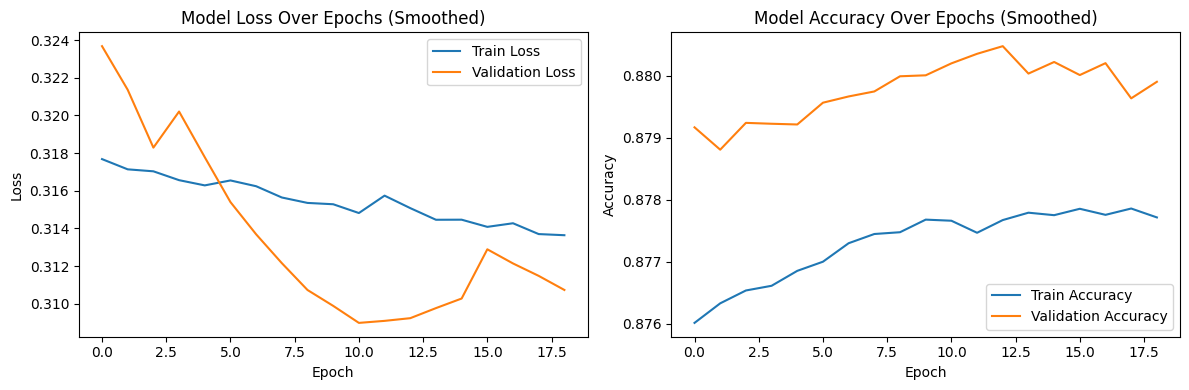

In [80]:
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

# Smoothing function
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Smooth the curves
smooth_train_loss = smooth_curve(history.history['loss'])
smooth_val_loss = smooth_curve(history.history['val_loss'])
smooth_train_acc = smooth_curve(history.history['accuracy'])
smooth_val_acc = smooth_curve(history.history['val_accuracy'])

# Plot smoothed training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(smooth_train_loss, label='Train Loss')
plt.plot(smooth_val_loss, label='Validation Loss')
plt.title('Model Loss Over Epochs (Smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot smoothed training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(smooth_train_acc, label='Train Accuracy')
plt.plot(smooth_val_acc, label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs (Smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


Epoch 1/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8799 - loss: 0.3124 - val_accuracy: 0.8792 - val_loss: 0.3082 - learning_rate: 0.0010
Epoch 2/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8762 - loss: 0.3220 - val_accuracy: 0.8124 - val_loss: 0.4218 - learning_rate: 0.0010
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8132 - loss: 0.3986 - val_accuracy: 0.8106 - val_loss: 0.4090 - learning_rate: 0.0010
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8216 - loss: 0.4009 - val_accuracy: 0.8124 - val_loss: 0.4092 - learning_rate: 0.0010
Epoch 5/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8244 - loss: 0.3875 - val_accuracy: 0.8124 - val_loss: 0.4059 - learning_rate: 0.0010
Epoch 6/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8309 - loss: 0.3857 - val_accuracy: 0.8124 - val_loss: 0.4264 - learning_rate: 0.0010
Epoch 7/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8253 - loss: 0.3943 - 

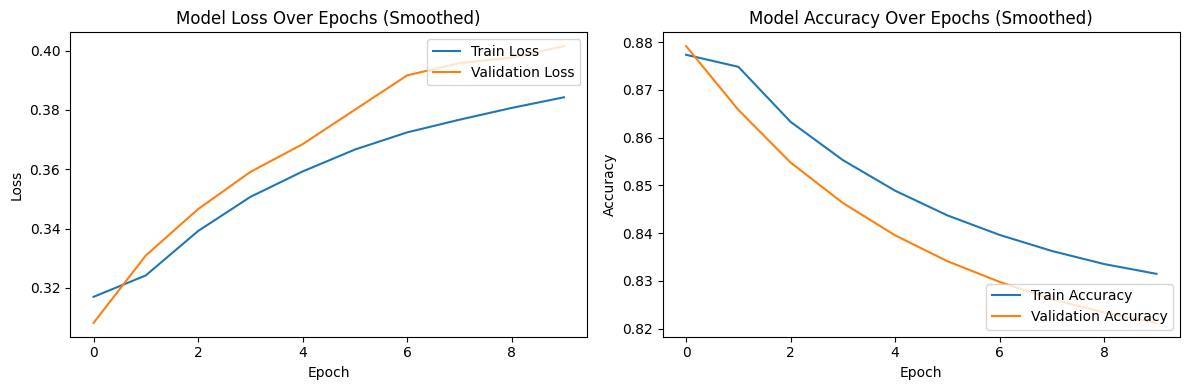

In [81]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Define a learning rate schedule function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return  float(lr * tf.math.exp(-0.1).numpy())

# Implement learning rate scheduler callback
lr_scheduler = LearningRateScheduler(scheduler)

# Train the model with early stopping and learning rate scheduler
history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping, lr_scheduler])

# Smooth the curves
smooth_train_loss = smooth_curve(history.history['loss'])
smooth_val_loss = smooth_curve(history.history['val_loss'])
smooth_train_acc = smooth_curve(history.history['accuracy'])
smooth_val_acc = smooth_curve(history.history['val_accuracy'])

# Plot smoothed training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(smooth_train_loss, label='Train Loss')
plt.plot(smooth_val_loss, label='Validation Loss')
plt.title('Model Loss Over Epochs (Smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot smoothed training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(smooth_train_acc, label='Train Accuracy')
plt.plot(smooth_val_acc, label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs (Smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


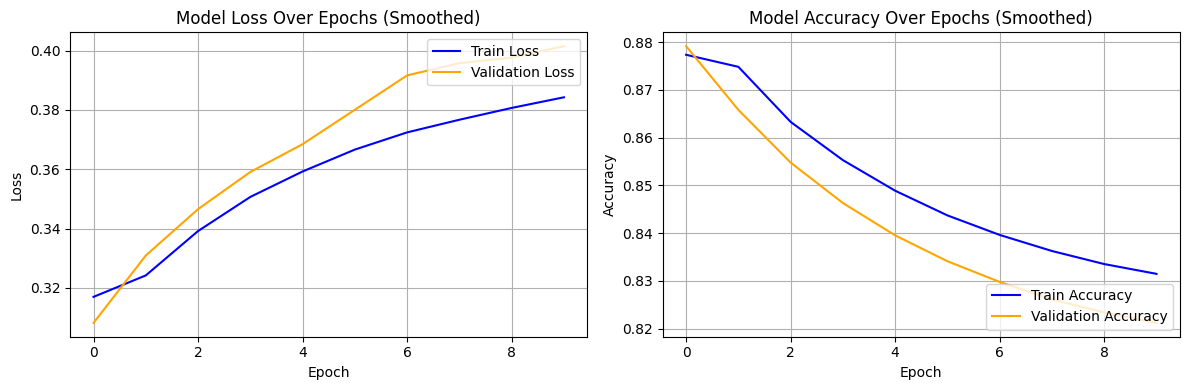

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Smoothing function
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Smooth the curves
smooth_train_loss = smooth_curve(history.history['loss'])
smooth_val_loss = smooth_curve(history.history['val_loss'])
smooth_train_acc = smooth_curve(history.history['accuracy'])
smooth_val_acc = smooth_curve(history.history['val_accuracy'])

# Enhanced Plot for Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(smooth_train_loss, label='Train Loss', color='blue')
plt.plot(smooth_val_loss, label='Validation Loss', color='orange')
plt.title('Model Loss Over Epochs (Smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

# Enhanced Plot for Accuracy
plt.subplot(1, 2, 2)
plt.plot(smooth_train_acc, label='Train Accuracy', color='blue')
plt.plot(smooth_val_acc, label='Validation Accuracy', color='orange')
plt.title('Model Accuracy Over Epochs (Smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()




)




# Mean Shap Values

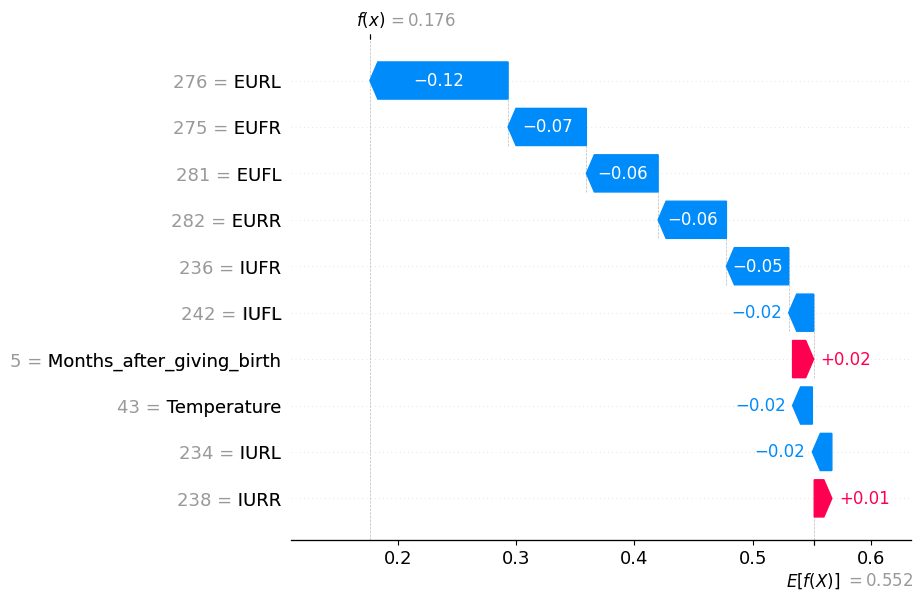

In [83]:
shap.plots.waterfall(shap_values_expl_1[0])

In [84]:
use_case_1 = pd.read_csv('/kaggle/input/test-cases/s3.UseCase.csv')
use_case_1

Months_after_giving_birth  IUFL  EUFL  IUFR  EUFR  IURL  EURL  IURR  EURR  \
0                          1   155   183   155   189   155   182   155   186   
1                          1   150   186   150   181   150   185   150   188   
2                          2   152   182   152   182   150   181   152   181   
3                          1   229   269   229   270   229   270   229   271   
4                          2   234   274   231   274   229   276   235   276   
5                          1   239   275   235   274   230   279   239   277   

   Temperature      ID  
0           39  Cow123  
1           41  Cow124  
2           38  Cow125  
3           40  Cow126  
4           41  Cow127  
5           42  Cow128

In [85]:
X_use_case_1 = use_case_1.drop(columns=[ 'ID'])
#X_use_case_1= use_case_1

In [86]:

n_features = X_use_case_1.shape[1]
X_use_case_1_reshape = X_use_case_1.values.reshape((X_use_case_1.shape[0], 1, n_features))

print(n_features)
X_use_case_1_reshape

10


array([[[  1, 155, 183, 155, 189, 155, 182, 155, 186,  39]],

       [[  1, 150, 186, 150, 181, 150, 185, 150, 188,  41]],

       [[  2, 152, 182, 152, 182, 150, 181, 152, 181,  38]],

       [[  1, 229, 269, 229, 270, 229, 270, 229, 271,  40]],

       [[  2, 234, 274, 231, 274, 229, 276, 235, 276,  41]],

       [[  1, 239, 275, 235, 274, 230, 279, 239, 277,  42]]])

In [87]:
len(X_use_case_1_reshape)

6

In [88]:
predicted_result = model.predict(X_use_case_1_reshape)
predicted_result
binary_result = (predicted_result > 0.1967).astype(int)
binary_result[:50]

proba = model.predict_step(X_use_case_1_reshape)
predicted_result


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


array([[0.19697064],
       [0.19697079],
       [0.19697104],
       [0.19697034],
       [0.19697027],
       [0.19697034]], dtype=float32)

In [89]:
binary_result = np.array([[0],
       [0],
       [0],
       [1],
       [1],
       [1]])

In [90]:
Y_use_case_1 = binary_result
Y_use_case_1

array([[0],
       [0],
       [0],
       [1],
       [1],
       [1]])

In [91]:
X_use_case_1_shap = X_use_case_1.values

X_use_case_1_shap 

array([[  1, 155, 183, 155, 189, 155, 182, 155, 186,  39],
       [  1, 150, 186, 150, 181, 150, 185, 150, 188,  41],
       [  2, 152, 182, 152, 182, 150, 181, 152, 181,  38],
       [  1, 229, 269, 229, 270, 229, 270, 229, 271,  40],
       [  2, 234, 274, 231, 274, 229, 276, 235, 276,  41],
       [  1, 239, 275, 235, 274, 230, 279, 239, 277,  42]])

In [92]:
explainer = shap.KernelExplainer(model_predict, shap.sample(X_use_case_1_shap, 100))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [93]:
shap_values_use_case_v1 = explainer.shap_values(X_use_case_1_shap, nsamples=100)

  0%|          | 0/6 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [94]:
shap_values_use_case_v1 

[array([[-0.01699708, -0.11362402,  0.06480601, -0.04165675,  0.03311801,
          0.        , -0.03210976,  0.        ,  0.0742023 ,  0.0322614 ],
        [ 0.02737602, -0.15840541,  0.0268242 , -0.0183042 ,  0.        ,
          0.0350025 ,  0.0003271 ,  0.        ,  0.08718002,  0.        ],
        [-0.00743237, -0.08780735,  0.        , -0.04607855,  0.04595644,
          0.        ,  0.        ,  0.        ,  0.09536233,  0.        ],
        [ 0.        ,  0.12719386, -0.00824975,  0.        ,  0.        ,
          0.        ,  0.        , -0.04604719, -0.07289718,  0.        ],
        [-0.06657203,  0.16916554, -0.02242096,  0.07652136, -0.09270263,
          0.02917471,  0.        ,  0.        , -0.09316633,  0.        ],
        [ 0.        ,  0.10142726,  0.        ,  0.        , -0.06583127,
          0.        ,  0.        ,  0.        , -0.03559625,  0.        ]])]

In [95]:
shap.initjs()
single_record_features =X_use_case_1_shap[0]
# Generate the force plot for the first record correctly
shap.force_plot(
    explainer.expected_value, shap_values_use_case_v1[0][5], single_record_features,     # Feature values for the single record
    feature_names=X_test.columns.tolist()  # Names of the features
)

In [96]:
shap.initjs()
single_record_features =X_use_case_1_shap[2]
# Generate the force plot for the first record correctly
shap.force_plot(
    explainer.expected_value, shap_values_use_case_v1[0][2], single_record_features,     # Feature values for the single record
    feature_names=X_test.columns.tolist()  # Names of the features
)

In [97]:
shap.initjs()
single_record_features =X_use_case_1_shap[0]
# Generate the force plot for the first record correctly
shap.force_plot(
    explainer.expected_value, shap_values_use_case_v1[0][0], single_record_features,     # Feature values for the single record
    feature_names=X_test.columns.tolist()  # Names of the features
)

In [98]:
shap.initjs()
single_record_features =X_use_case_1_shap[1]
# Generate the force plot for the first record correctly
shap.force_plot(
    explainer.expected_value, shap_values_use_case_v1[0][1], single_record_features,     # Feature values for the single record
    feature_names=X_test.columns.tolist()  # Names of the features
)

In [99]:
shap.initjs()
single_record_features =X_use_case_1_shap[3]
# Generate the force plot for the first record correctly
shap.force_plot(
    explainer.expected_value, shap_values_use_case_v1[0][3], single_record_features,     # Feature values for the single record
    feature_names=X_test.columns.tolist()  # Names of the features
)

In [100]:
shap.initjs()
single_record_features =X_use_case_1_shap[5]
# Generate the force plot for the first record correctly
shap.force_plot(
    explainer.expected_value, shap_values_use_case_v1[0][4], single_record_features,     # Feature values for the single record
    feature_names=X_test.columns.tolist()  # Names of the features
)

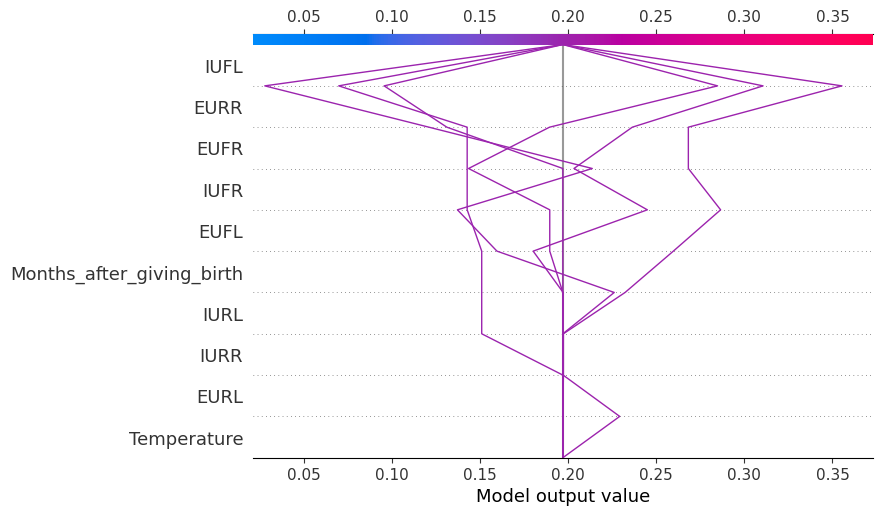

In [101]:
shap.decision_plot(explainer.expected_value, shap_values_use_case_v1[0], feature_names=X_test.columns.tolist(),)

In [102]:
shap_values_use_case_v1

[array([[-0.01699708, -0.11362402,  0.06480601, -0.04165675,  0.03311801,
          0.        , -0.03210976,  0.        ,  0.0742023 ,  0.0322614 ],
        [ 0.02737602, -0.15840541,  0.0268242 , -0.0183042 ,  0.        ,
          0.0350025 ,  0.0003271 ,  0.        ,  0.08718002,  0.        ],
        [-0.00743237, -0.08780735,  0.        , -0.04607855,  0.04595644,
          0.        ,  0.        ,  0.        ,  0.09536233,  0.        ],
        [ 0.        ,  0.12719386, -0.00824975,  0.        ,  0.        ,
          0.        ,  0.        , -0.04604719, -0.07289718,  0.        ],
        [-0.06657203,  0.16916554, -0.02242096,  0.07652136, -0.09270263,
          0.02917471,  0.        ,  0.        , -0.09316633,  0.        ],
        [ 0.        ,  0.10142726,  0.        ,  0.        , -0.06583127,
          0.        ,  0.        ,  0.        , -0.03559625,  0.        ]])]

In [103]:
shap_values_use_case_v1_flat = np.array(shap_values_use_case_v1).reshape((6, 10))

In [104]:

use_case_values_expl = shap.Explanation(values=shap_values_use_case_v1_flat, base_values=explainer.expected_value, data=X_use_case_1_shap, feature_names=X_use_case_1.columns.tolist())

use_case_values_expl

.values =
array([[-0.01699708, -0.11362402,  0.06480601, -0.04165675,  0.03311801,
         0.        , -0.03210976,  0.        ,  0.0742023 ,  0.0322614 ],
       [ 0.02737602, -0.15840541,  0.0268242 , -0.0183042 ,  0.        ,
         0.0350025 ,  0.0003271 ,  0.        ,  0.08718002,  0.        ],
       [-0.00743237, -0.08780735,  0.        , -0.04607855,  0.04595644,
         0.        ,  0.        ,  0.        ,  0.09536233,  0.        ],
       [ 0.        ,  0.12719386, -0.00824975,  0.        ,  0.        ,
         0.        ,  0.        , -0.04604719, -0.07289718,  0.        ],
       [-0.06657203,  0.16916554, -0.02242096,  0.07652136, -0.09270263,
         0.02917471,  0.        ,  0.        , -0.09316633,  0.        ],
       [ 0.        ,  0.10142726,  0.        ,  0.        , -0.06583127,
         0.        ,  0.        ,  0.        , -0.03559625,  0.        ]])

.base_values =
array([0.19697057])

.data =
array([[  1, 155, 183, 155, 189, 155, 182, 155, 186,  39],
   

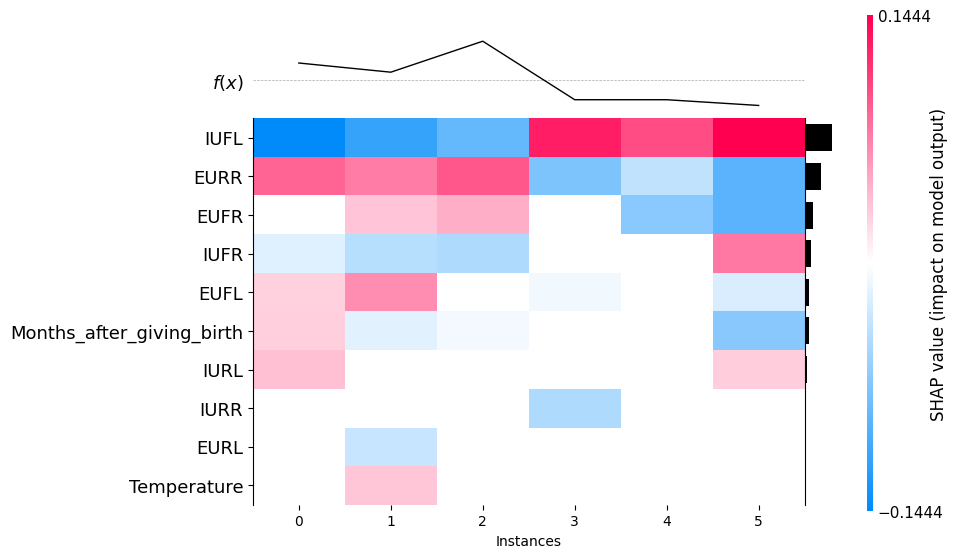

In [105]:
shap.plots.heatmap(use_case_values_expl, max_display=15)

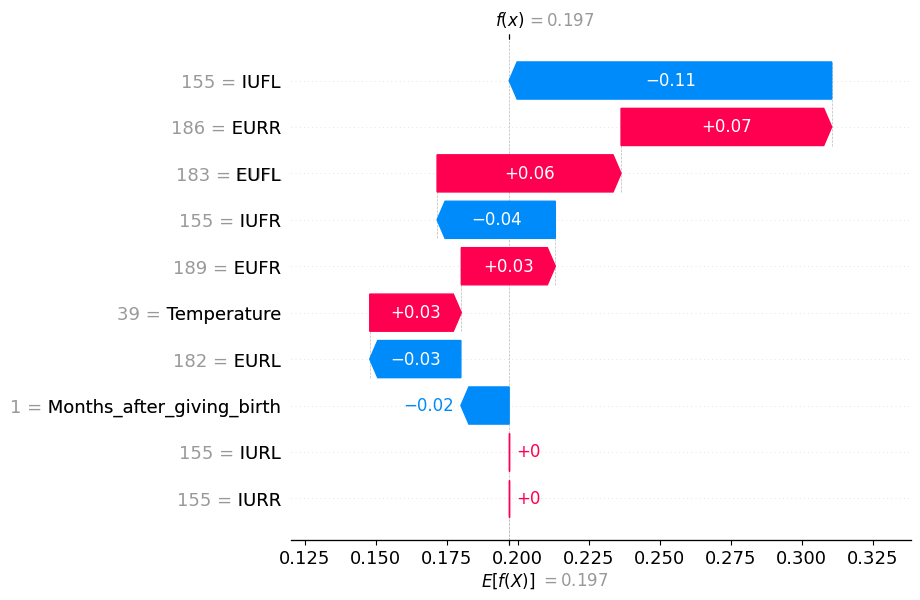

In [106]:
shap.plots.waterfall(use_case_values_expl[0])

In [107]:
# Print the number of explanations in use_case_values_expl
print(f"Number of explanations: {len(use_case_values_expl)}")

# Print the shape of the values in use_case_values_expl
print(f"Shape of values: {use_case_values_expl.values.shape}")

# Print the first few values to see the structure
print("Values:", use_case_values_expl.values[:5])
print("Base values:", use_case_values_expl.base_values)
print("Data:", use_case_values_expl.data[:5])


Number of explanations: 6
Shape of values: (6, 10)
Values: [[-0.01699708 -0.11362402  0.06480601 -0.04165675  0.03311801  0.
  -0.03210976  0.          0.0742023   0.0322614 ]
 [ 0.02737602 -0.15840541  0.0268242  -0.0183042   0.          0.0350025
   0.0003271   0.          0.08718002  0.        ]
 [-0.00743237 -0.08780735  0.         -0.04607855  0.04595644  0.
   0.          0.          0.09536233  0.        ]
 [ 0.          0.12719386 -0.00824975  0.          0.          0.
   0.         -0.04604719 -0.07289718  0.        ]
 [-0.06657203  0.16916554 -0.02242096  0.07652136 -0.09270263  0.02917471
   0.          0.         -0.09316633  0.        ]]
Base values: [0.19697057]
Data: [[  1 155 183 155 189 155 182 155 186  39]
 [  1 150 186 150 181 150 185 150 188  41]
 [  2 152 182 152 182 150 181 152 181  38]
 [  1 229 269 229 270 229 270 229 271  40]
 [  2 234 274 231 274 229 276 235 276  41]]


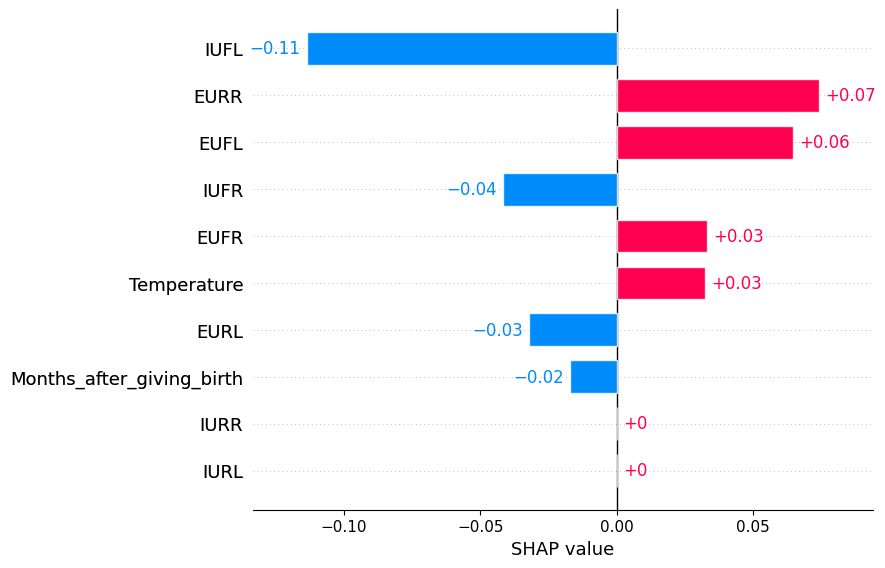

In [108]:
shap.plots.bar(use_case_values_expl[0])

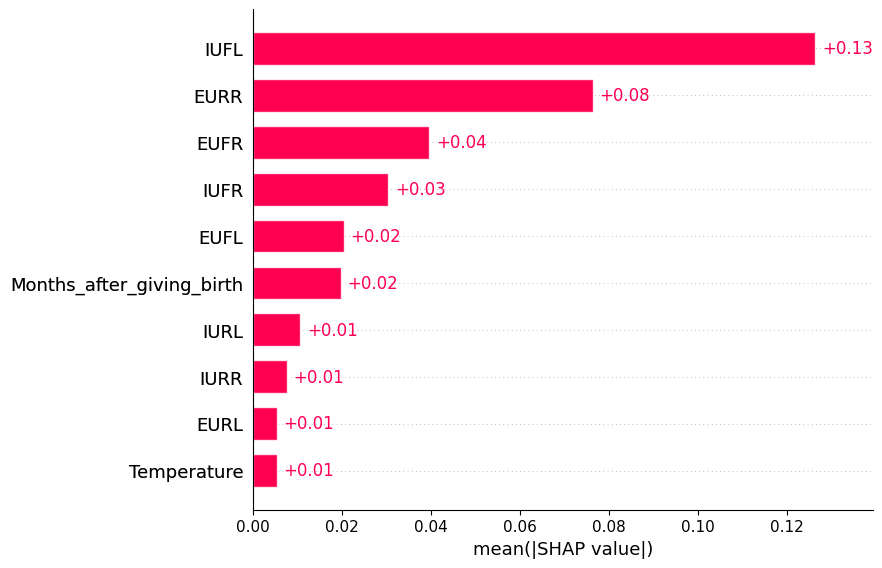

In [109]:
shap.plots.bar(use_case_values_expl)

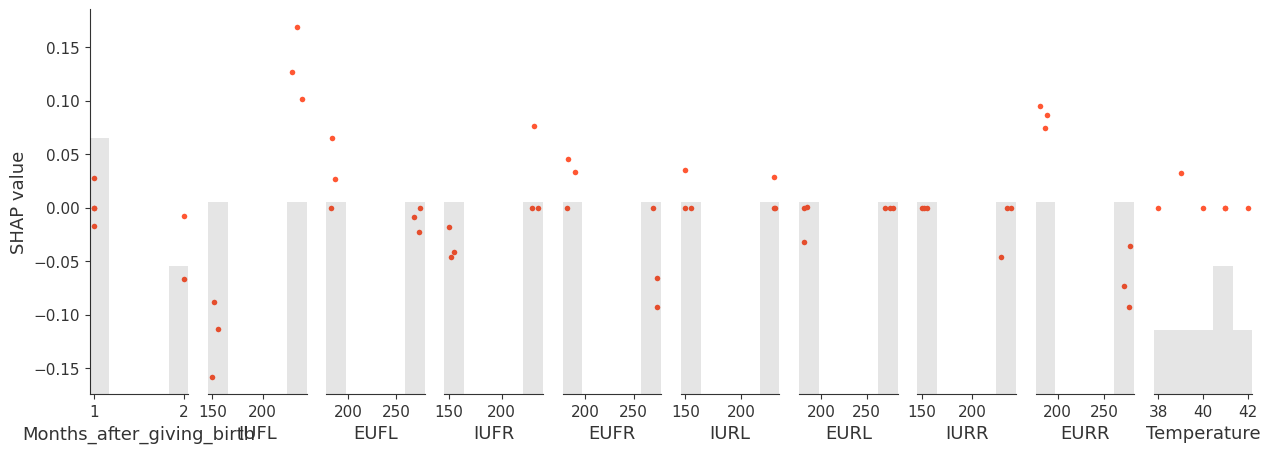

In [110]:
shap.plots.scatter(use_case_values_expl,color="#FF5733",hist=True, axis_color="#335BFF", dot_size=16, x_jitter="auto", alpha=1, title="Mastitis Scatter Plot", xmin=None, xmax=None, ymin=None, ymax=None, overlay=None, ax=None, ylabel="SHAP value", show=True)


In [111]:
len(use_case_values_expl)
shap_values_use_case_v1 = np.array(shap_values_use_case_v1)

In [112]:
# Extract feature names
feature_names = X_use_case_1.columns.tolist()  # Exclude 'Predicted Probability' and 'Actual Label'

shap_values_use_case_v1 = np.array(shap_values_use_case_v1)
# Prepare the SHAP explanation object
use_case_values_expl = shap.Explanation(
    values=shap_values_use_case_v1,
    base_values=[0.12711417] * shap_values_use_case_v1.shape[0],  # Adjust base values accordingly
    data=X_use_case_1[feature_names].values,
    feature_names=feature_names
)

In [113]:
# Reshape the SHAP values to remove the extra dimension
shap_values_use_case_v1 = shap_values_use_case_v1.reshape(-1, shap_values_use_case_v1.shape[-1])

shap_values_use_case_v1[2]
base_value = 0.12711417
base_value + sum(shap_values_use_case_v1[2])


0.12711467167242688

In [114]:
 len(Y_use_case_1)

6

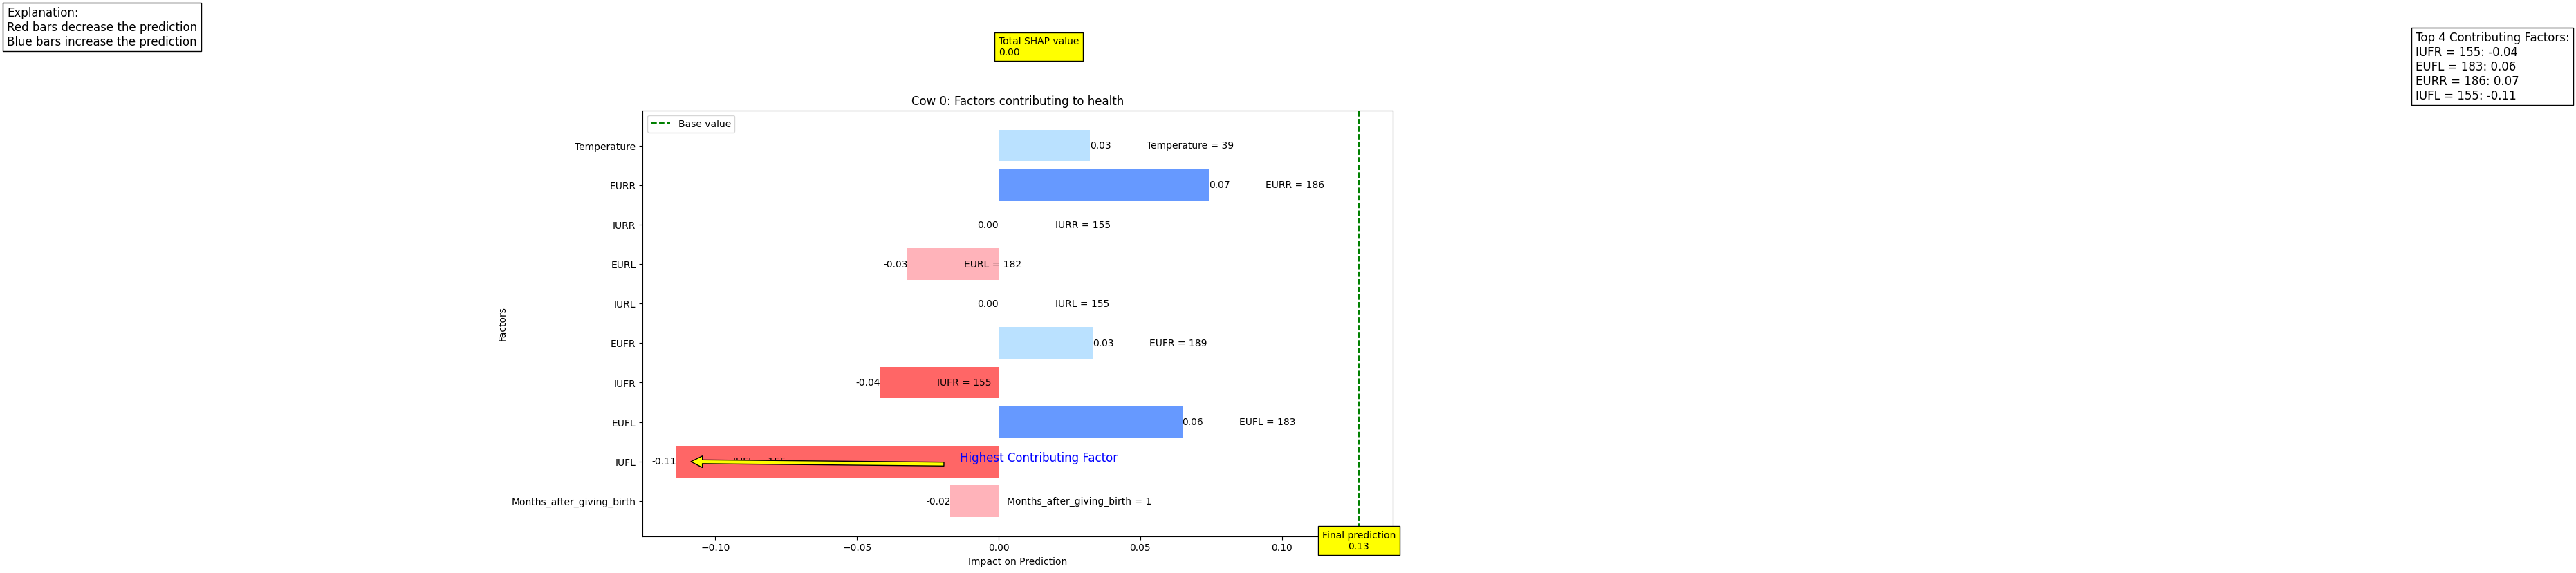

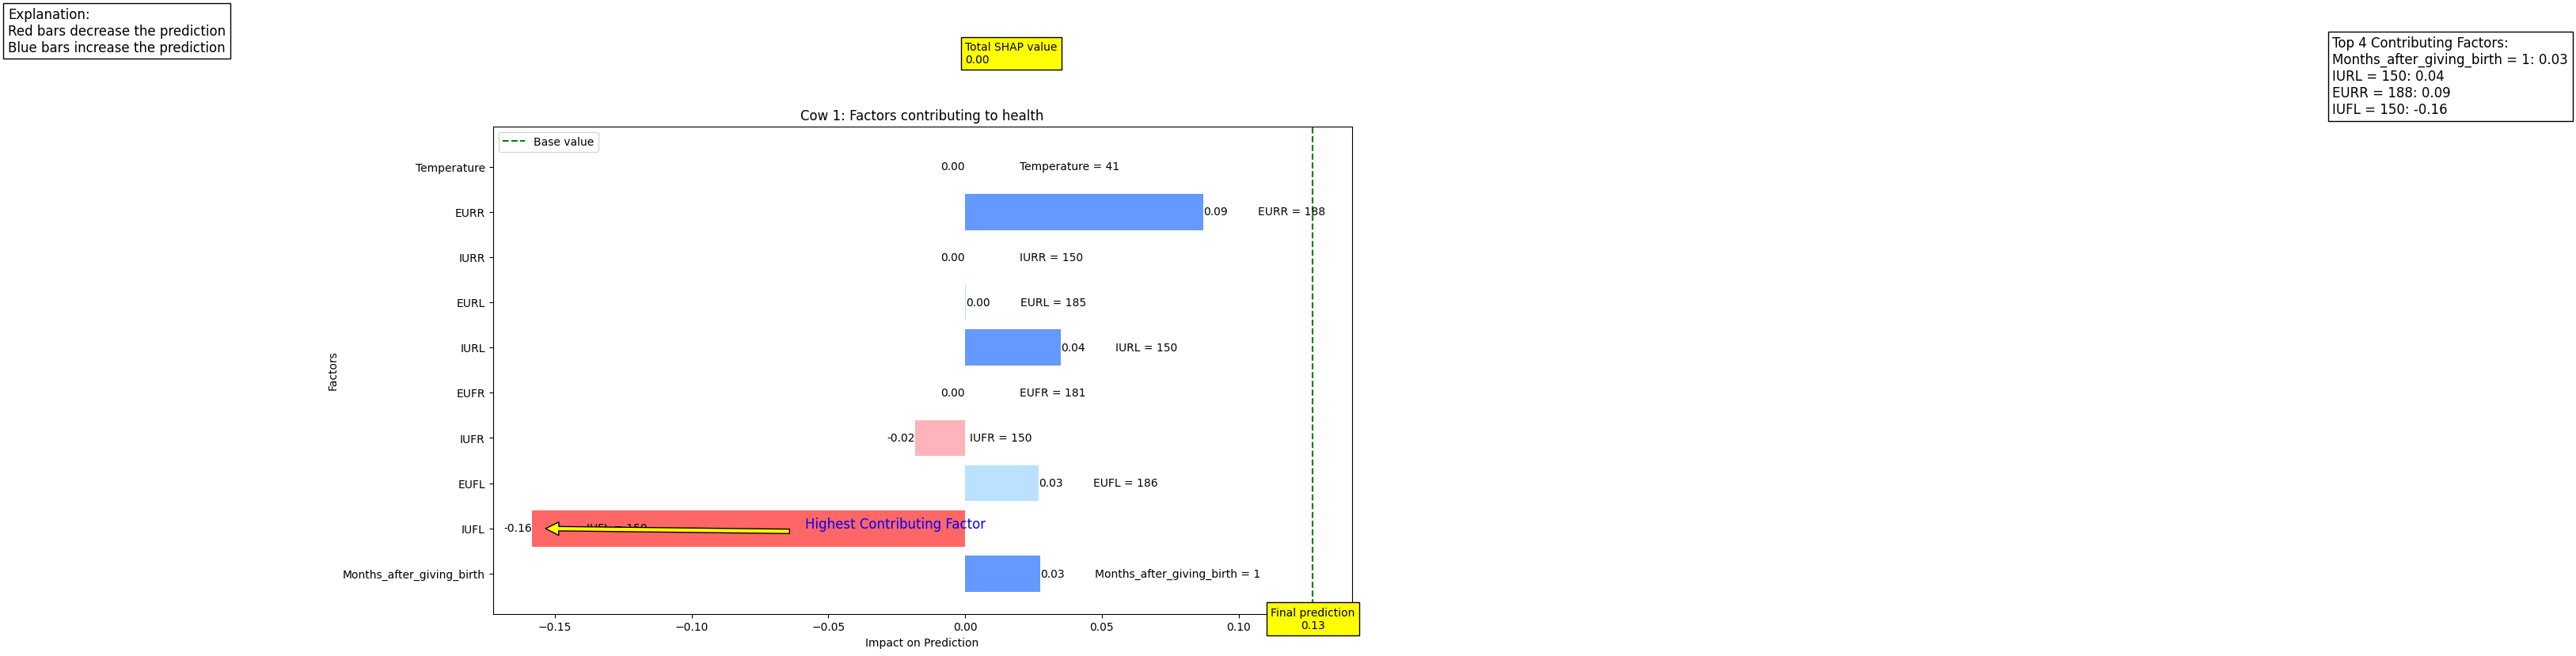

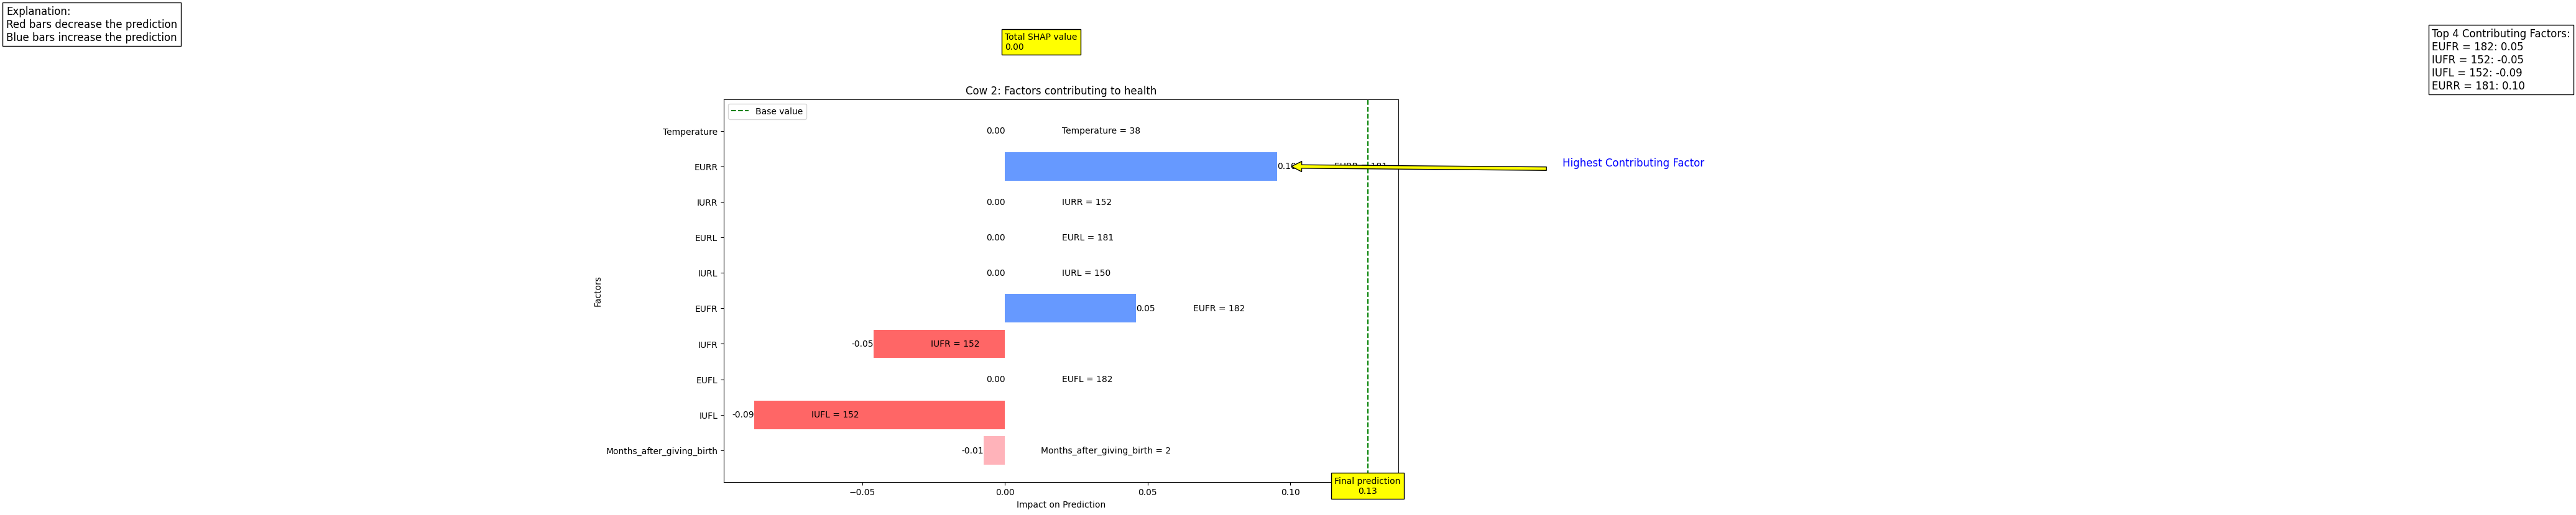

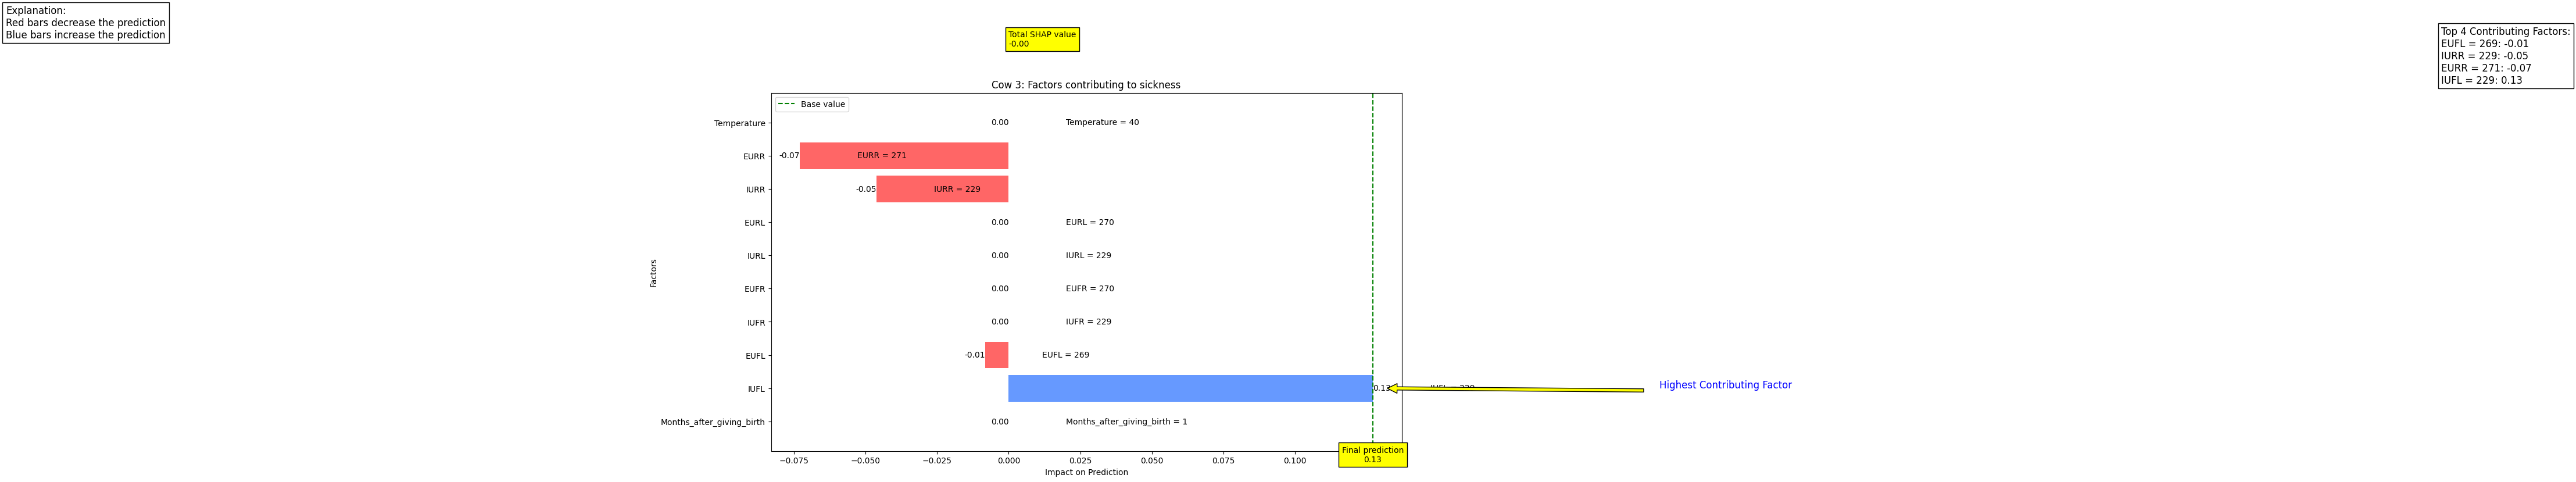

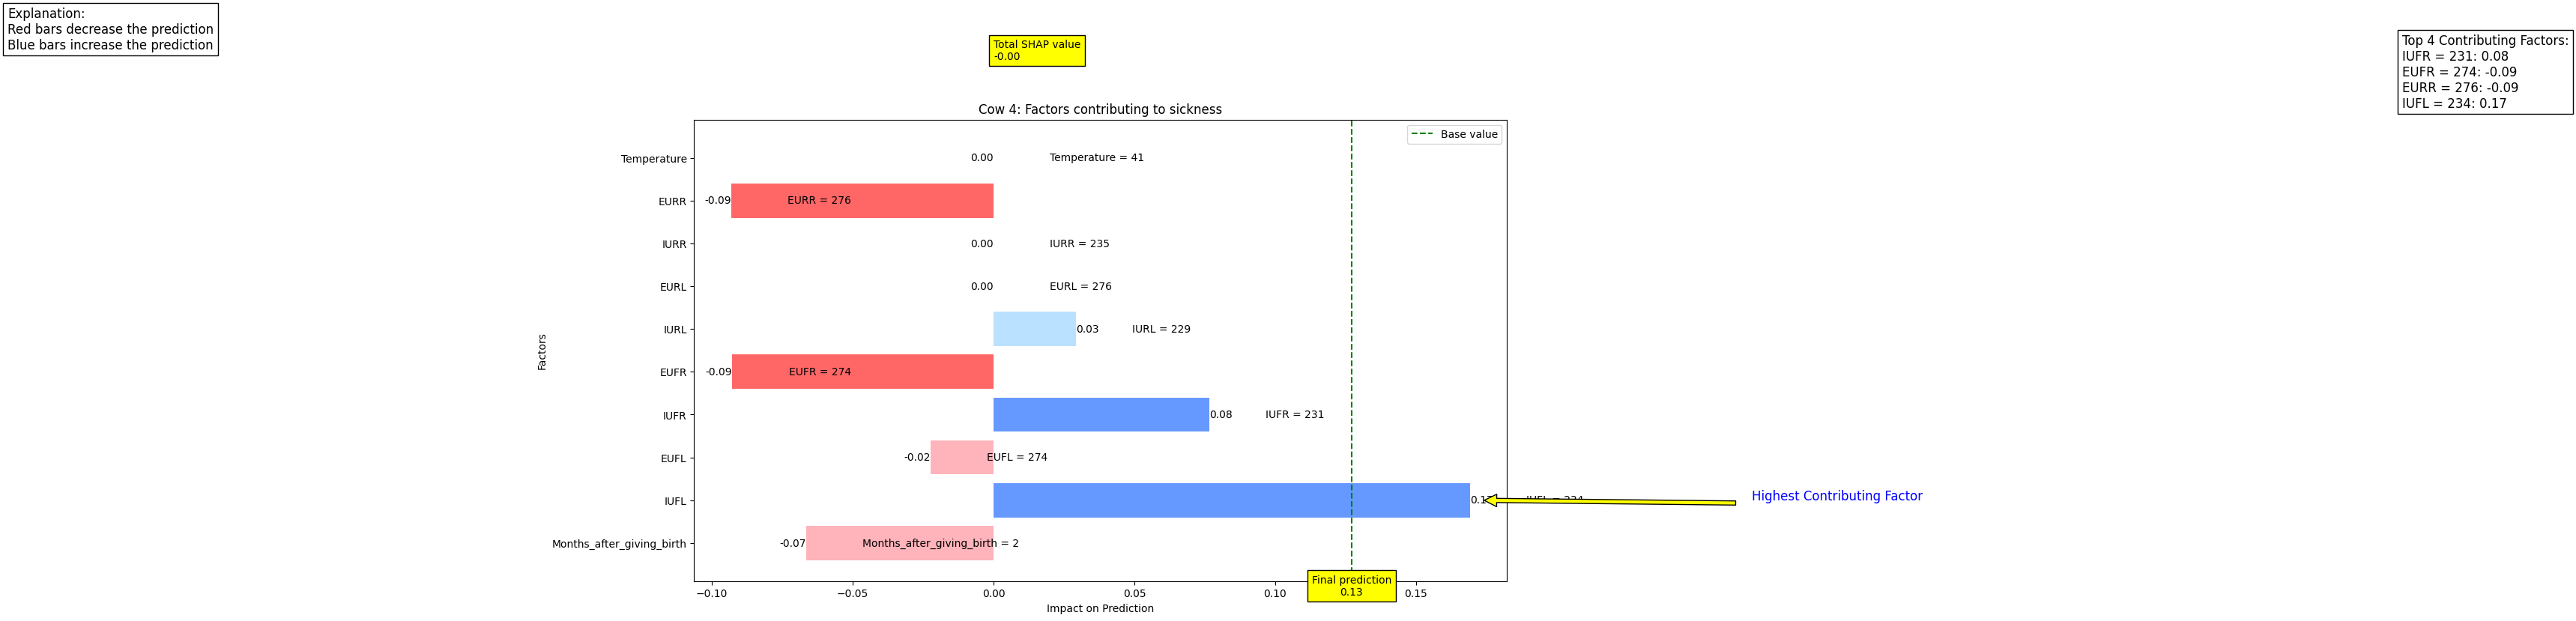

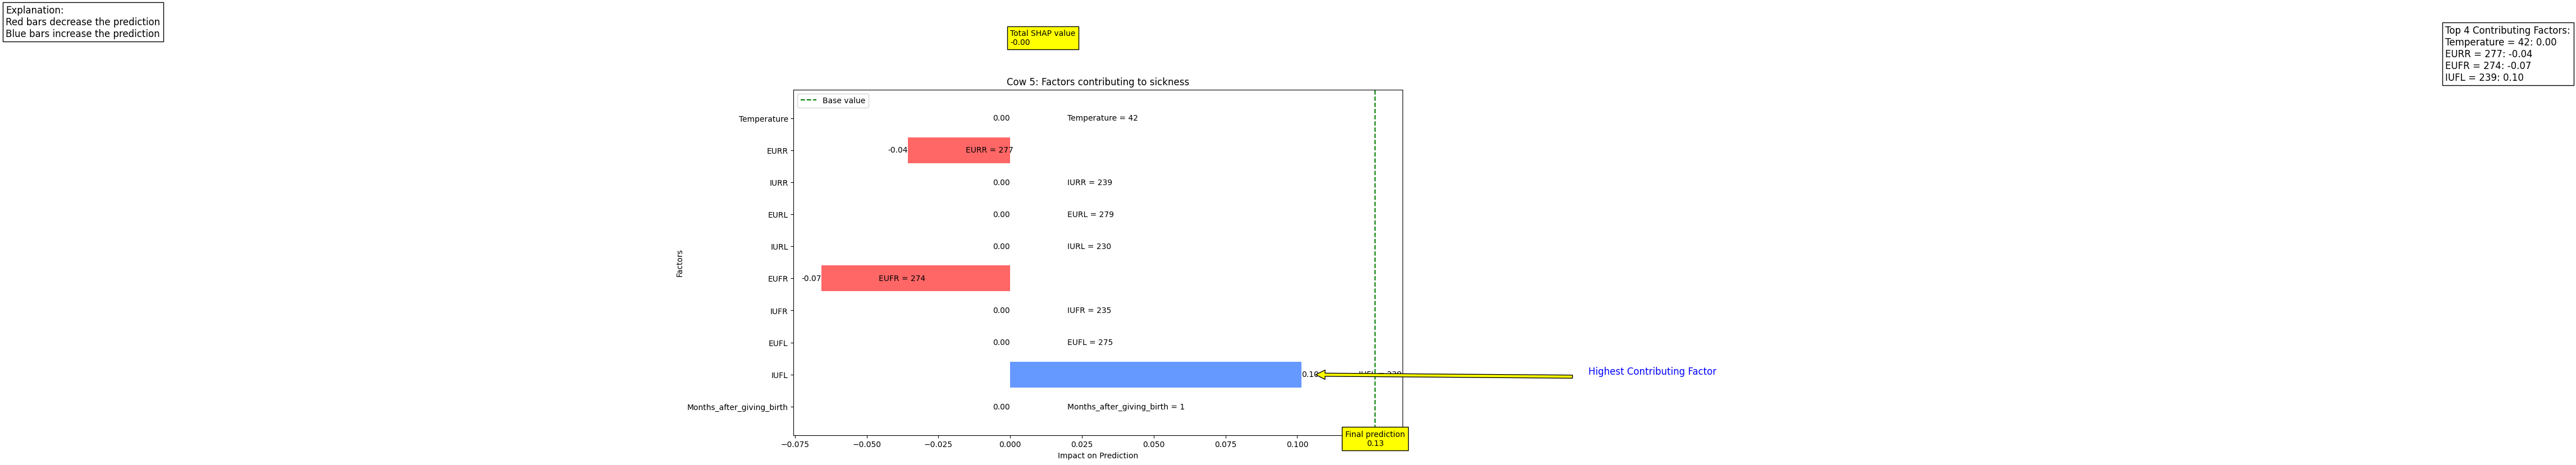

Custom waterfall plots generated for each cow.


In [115]:
# Function to create and save custom waterfall plots
def create_custom_waterfall_plot(shap_values, feature_values, base_value, cow_id, is_sick, filename):
    # Calculate the final prediction
    final_prediction = base_value + sum(shap_values)

    # Pastel colors for the bars
    colors = ['#FFB3BA' if val < 0 else '#BAE1FF' for val in shap_values]

    # Identify the top 4 contributing factors by absolute SHAP value
    top_4_indices = np.argsort(np.abs(shap_values))[-4:]

    # Highlight top 4 contributing factors
    highlight_colors = ['#FF6666' if val < 0 else '#6699FF' for val in shap_values]
    for i in top_4_indices:
        colors[i] = highlight_colors[i]

    # Positions for the bars
    positions = np.arange(len(feature_names))

    # Create the plot
    plt.figure(figsize=(14, 8))
    bars = plt.barh(positions, shap_values, color=colors)

    # Add the base value as a vertical line
    plt.axvline(base_value, color='green', linestyle='--', label='Base value')

    # Add annotations for the SHAP values and feature names
    for bar, feature, val in zip(bars, feature_values, shap_values):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{val:.2f}', va='center', ha='left' if val > 0 else 'right', color='black')
        plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height() / 2, feature, va='center', ha='left', color='black')

    # Add explanations for the top 4 contributing factors
    explanation_text = 'Top 4 Contributing Factors:\n'
    for i in top_4_indices:
        explanation_text += f"{feature_values[i]}: {shap_values[i]:.2f}\n"
    plt.text(0.5, len(feature_names) + 1, explanation_text.strip(), va='center', ha='left', color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))

    # Highlight the highest contributing factor
    max_shap_value = max(shap_values, key=abs)
    max_feature_index = shap_values.tolist().index(max_shap_value)
    plt.annotate('Highest Contributing Factor',
                 xy=(shap_values[max_feature_index], max_feature_index),
                 xytext=(shap_values[max_feature_index] + 0.1, max_feature_index),
                 arrowprops=dict(facecolor='yellow', shrink=0.05),
                 fontsize=12, color='blue', ha='left')

    # Add the final prediction as an annotation
    plt.text(final_prediction, -1, f'Final prediction\n{final_prediction:.2f}', va='center', ha='center', color='black', bbox=dict(facecolor='yellow', edgecolor='black'))

    # Add the total SHAP value as an annotation
    total_shap_value = sum(shap_values)
    plt.text(total_shap_value, len(feature_names) + 1.5, f'Total SHAP value\n{total_shap_value:.2f}', va='center', ha='left', color='black', bbox=dict(facecolor='yellow', edgecolor='black'))

    # Set labels and title
    plt.xlabel('Impact on Prediction')
    plt.ylabel('Factors')
    plt.title(f'Cow {cow_id}: Factors contributing to {"sickness" if is_sick else "health"}')
    plt.yticks(positions, feature_names)

    # Add explanation for colors
    plt.text(-0.35, len(feature_names) + 2, 'Explanation:\nRed bars decrease the prediction\nBlue bars increase the prediction',
             va='center', ha='left', color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))

    plt.legend()
    plt.show()
    # Save the plot
    plt.savefig(f'{filename}.png')
    plt.close()

# Loop through each cow and create a plot
for i in range(len(shap_values_use_case_v1)):
    cow_id = i  # Adjust according to your CSV structure
    is_sick = Y_use_case_1[i]
    shap_values = shap_values_use_case_v1[i]
    feature_values = X_use_case_1.iloc[i].tolist()  # Exclude 'Predicted Probability' and 'Actual Label'
    feature_values = [f"{name} = {value}" for name, value in zip(feature_names, feature_values)]
    create_custom_waterfall_plot(shap_values, feature_values, 0.12711417, cow_id, is_sick, f'prediction_force_plot_{i}')

print("Custom waterfall plots generated for each cow.")